In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import os
from astropy.modeling import models
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from scipy.special import voigt_profile
import Analysis_functions as AF
from importlib import reload
from scipy.interpolate import interp1d

# Get the spectra for a given day

In [2]:
#Defining the directory names used to extract the data.
day = '2023-02-03'
location = '/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/Solar-data/'+day
os.chdir(location)
dir_name = 'Corr-data'
blaze_dir = 'Blaze-data'
CCF_dir_name = 'CCF_RV-data'

#Creating a directory to store the results.
if not os.path.exists('Plot_Results'):
    os.mkdir('Plot_Results')

# Extract data

In [3]:
reload(AF)

#Extracting the data
tot_lamda, tot_spctr, tot_norm_spctr, tot_err, tot_norm_err, tot_SNR, tot_mode, tot_date, tot_RV, tot_RV_err, tot_FWHM, tot_FWHM_err, tot_BIS_SPAN, tot_BIS_SPAN_err, tot_H2O, tot_H2O_err, tot_O2, tot_O2_err, tot_CO2, tot_CO2_err, tot_AIRM = AF.extraction(dir_name, blaze_dir, CCF_dir_name, 14)



# Data reduction

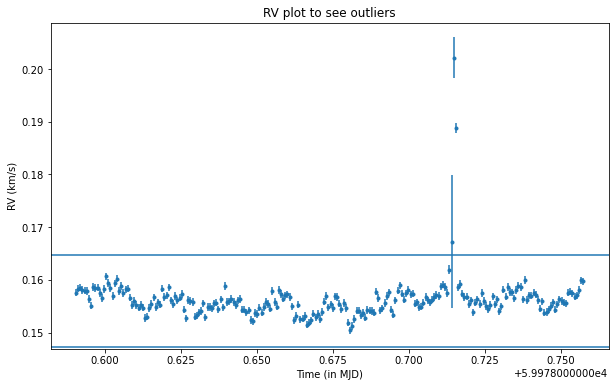

In [4]:
reload(AF)
#Defining a variable to save or not the results.
save = False

#Plotting the RV time series to see the cut and the possible outliers.
    
IQR = np.percentile(tot_RV, 75)-np.percentile(tot_RV, 25)

plt.figure(figsize=[10, 6])
plt.errorbar(tot_date, tot_RV, yerr = tot_RV_err, fmt='.')
plt.axhline((1+20*IQR)*np.median(tot_RV))
plt.axhline((1-20*IQR)*np.median(tot_RV))
plt.xlabel('Time (in MJD)')
plt.ylabel('RV (km/s)')
plt.title('RV plot to see outliers')
plt.show()


In [5]:
reload(AF)

sig = 200

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):
    
    #Performing the data reduction by SNR and RV clipping.
    total_SNR_HA, total_SNR_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_SNR, tot_RV, tot_AIRM, sig)
    
    total_spctr_HA, total_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_spctr, tot_RV, tot_AIRM, sig)

    tota_norm_spctr_HA, tota_norm_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_spctr, tot_RV, tot_AIRM, sig)

    total_lamda_HA, total_lamda_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_lamda, tot_RV, tot_AIRM, sig)
    
    total_err_HA, total_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_err, tot_RV, tot_AIRM, sig)

    tota_norm_err_HA, tota_norm_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_err, tot_RV, tot_AIRM, sig)
    
    date_HA, date_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_date, tot_RV, tot_AIRM, sig)


#If there is one mode of observation
else:
    
    #Performing the data reduction by SNR and RV clipping.
    
    total_SNR = AF.segment_and_reduce(tot_mode, tot_SNR, tot_SNR, tot_RV, tot_AIRM, sig)

    total_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, tot_spctr, tot_RV, tot_AIRM, sig)

    tota_norm_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_spctr, tot_RV, tot_AIRM, sig)

    total_lamda = AF.segment_and_reduce(tot_mode, tot_SNR, tot_lamda, tot_RV, tot_AIRM, sig)
    
    total_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_err, tot_RV, tot_AIRM, sig)

    tota_norm_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_err, tot_RV, tot_AIRM, sig)
    
    date = AF.segment_and_reduce(tot_mode, tot_SNR, tot_date, tot_RV, tot_AIRM, sig)
    
mode = tot_mode

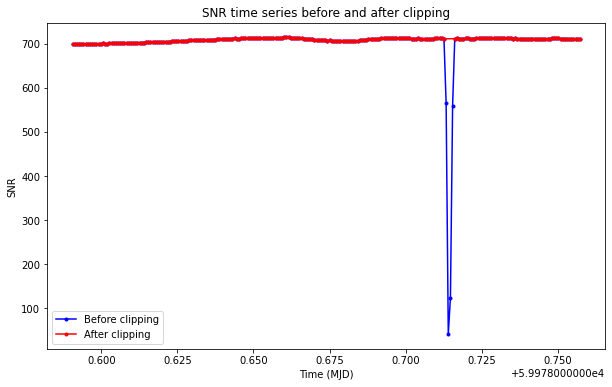

In [6]:
#Plotting the SNR time series to make sure the outliers have been removed
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):
    plt.figure(figsize=[10, 6])
    plt.plot(tot_date, tot_SNR, 'b.', linestyle='-', label='Before clipping')
    plt.plot(date_HA, total_SNR_HA, 'r.', linestyle='-', label='After clipping')
    plt.plot(date_HE, total_SNR_HE, 'r.', linestyle='-')
    plt.xlabel('Time (MJD)')
    plt.ylabel('SNR')
    plt.title('SNR time series before and after clipping')
    plt.legend()
else:
    plt.figure(figsize=[10, 6])
    plt.plot(tot_date, tot_SNR, 'b.', linestyle='-', label='Before clipping')
    plt.plot(date, total_SNR, 'r.', linestyle='-', label='After clipping')
    plt.xlabel('Time (MJD)')
    plt.ylabel('SNR')
    plt.title('SNR time series before and after clipping')
    plt.legend()

# Interpolation to have fixed wavelength grid

In [7]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):

    min_lamda = max(max(total_lamda_HA[:, 0]), max(total_lamda_HE[:, 0]))
    max_lamda = min(min(total_lamda_HA[:, -1]), min(total_lamda_HE[:, -1]))

    step = (np.mean(np.diff(total_lamda_HA))+np.mean(np.diff(total_lamda_HE)))/2
    
    ref_wave = np.linspace(min_lamda, max_lamda, len(total_lamda_HA[0]))
    
    total_norm_spctr_HA = np.zeros(tota_norm_spctr_HA.shape)
    total_norm_spctr_HE = np.zeros(tota_norm_spctr_HE.shape)
    
    total_norm_err_HA = np.zeros(tota_norm_err_HA.shape)
    total_norm_err_HE = np.zeros(tota_norm_err_HE.shape)
    
    for i in range(len(tota_norm_spctr_HA)):
        
        interpol_s = interp1d(total_lamda_HA[i], tota_norm_spctr_HA[i])
        total_norm_spctr_HA[i] = interpol_s(ref_wave)
        
        
        interpol_err = interp1d(total_lamda_HA[i], tota_norm_err_HA[i])
        total_norm_err_HA[i] = interpol_err(ref_wave)
        
    for i in range(len(tota_norm_spctr_HE)):
        
        interpol_s = interp1d(total_lamda_HE[i], tota_norm_spctr_HE[i])
        total_norm_spctr_HE[i] = interpol_s(ref_wave)
        
        
        interpol_err = interp1d(total_lamda_HE[i], tota_norm_err_HE[i])
        total_norm_err_HE[i] = interpol_err(ref_wave)
        
else:
    
    min_lamda = max(total_lamda[:, 0])
    max_lamda = min(total_lamda[:, -1])

    step = np.mean(np.diff(total_lamda))
    
    ref_wave = np.linspace(min_lamda, max_lamda, len(total_lamda[0]))
    
    total_norm_spctr = np.zeros(tota_norm_spctr.shape)

    total_norm_err = np.zeros(tota_norm_err.shape)
        
    for i in range(len(tota_norm_spctr)):
        
        interpol_s = interp1d(total_lamda[i], tota_norm_spctr[i])
        total_norm_spctr[i] = interpol_s(ref_wave)
        
        
        interpol_err = interp1d(total_lamda[i], tota_norm_err[i])
        total_norm_err[i] = interpol_err(ref_wave)

# Planetary signal simulation

In [8]:
###################################################################################
################# ADAPTED FROM WILLIAM DETHIER'S CODE #############################
###################################################################################

In [9]:
os.chdir('/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet')
import spectrum_model as spec_mod

In [10]:
##Defining the parameters for the planetary abosprtion simulation

# Helium density
density = 5e14

# Helium temperature -- thermal broadening
temperature = 10000

# Stellar rotation velocity -- non-thermal broadening
vsini = 2

# Reference medium for the wavelengths
medium= "VACUUM"

# Instrumental resolving power e.g. R_pow = 70000
# For non thermal broadening
# see spectrum_he() in spectrum_model.py to know where to write the argument

if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    R_power_HE = 74000
    R_power_HA = 86000
else:
    if mode[0] == 'A':
        R_power = 86000
    else:
        R_power = 74000
# Microturbulence
# for non thermal broadening
# micro_t = 1

# You can change the damping to have Voigt profiles, by default you have Gaussian profiles
# Set to value greater than 0
# d_damping = 0

## Simulating on one spectrum to see what it looks like

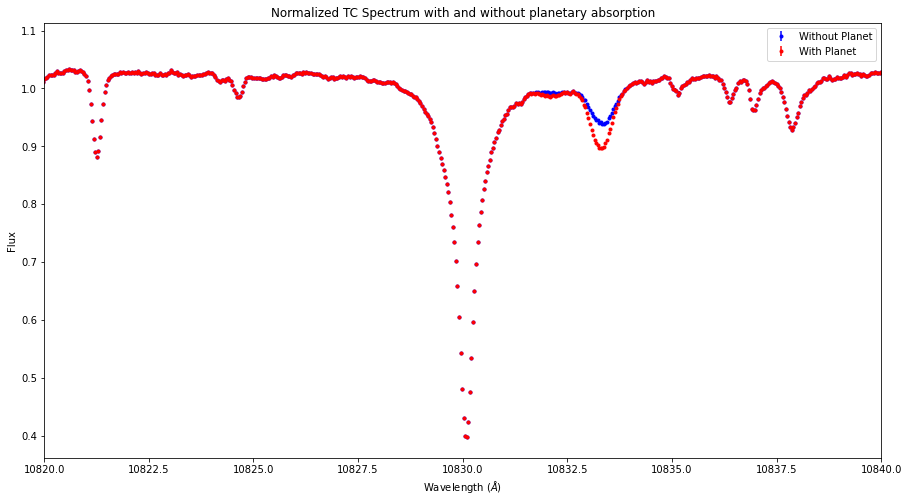

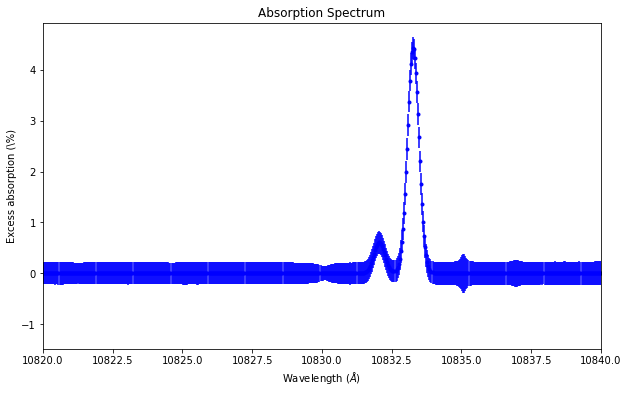

In [11]:
reload(AF)

#Random index of the spectrum to plot.
idx = 10

#Defining a variable to save or not the results.
save = False

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    #Making a theoretical spectra with a planetary absorption signal to see what it looks like.
    
    theoretical_spctr = spec_mod.spectrum_he(ref_wave, total_norm_spctr_HE[idx], temperature, density, vsini, medium, R_pow = R_power_HE)
    theoretical_err = spec_mod.spectrum_he(ref_wave, total_norm_err_HE[idx], temperature, density, vsini, medium, R_pow = R_power_HE)

    #Plotting the current spectra with and without a planetary signal.
    plt.figure(figsize=[15, 8])
    plt.errorbar(ref_wave, total_norm_spctr_HE[idx], yerr = total_norm_err_HE[idx], fmt='b.', label='Without Planet')
    plt.errorbar(ref_wave, theoretical_spctr, yerr = theoretical_err, fmt='r.', label='With Planet')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim([10820, 10840])
    plt.legend()
    plt.title('Normalized TC Spectrum with and without planetary absorption for HE')
    if save:
        plt.savefig('/Users/samsonmercier/Desktop/Planet.pdf')
    plt.show()
    
    #Plotting the absorption spectrum of the fake planet.
    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, (total_norm_spctr_HE[idx]-theoretical_spctr)*100, yerr = np.sqrt(total_norm_err_HE[idx]**2+theoretical_err**2)*100, fmt='b.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.title('Absorption Spectrum')
    plt.ylabel('Excess absorption (%)')
    plt.xlim([10820, 10840])
    plt.show()

#If there is one mode of observation
else:
    
    #Making a theoretical spectra with a planetary absorption signal to see what it looks like.

    theoretical_spctr = spec_mod.spectrum_he(ref_wave, total_norm_spctr[idx], temperature, density, vsini, medium, R_pow = R_power)
    theoretical_err = spec_mod.spectrum_he(ref_wave, total_norm_err[idx], temperature, density, vsini, medium, R_pow = R_power)

    #Plotting the current spectra with and without a planetary signal.
    plt.figure(figsize=[15, 8])
    plt.errorbar(ref_wave, total_norm_spctr[idx], yerr = total_norm_err[idx], fmt='b.', label='Without Planet')
    plt.errorbar(ref_wave, theoretical_spctr, yerr = total_norm_err[idx], fmt='r.', label='With Planet')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim([10820, 10840])
    plt.legend()
    plt.title('Normalized TC Spectrum with and without planetary absorption')
    if save:
        plt.savefig('/Users/samsonmercier/Desktop/Planet.pdf')
    plt.show()
    
    #Plotting the absorption spectrum of the fake planet.
    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, (total_norm_spctr[idx]-theoretical_spctr)*100, yerr = np.sqrt(total_norm_err[idx]**2+theoretical_err**2)*100, fmt='b.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.title('Absorption Spectrum')
    plt.ylabel('Excess absorption (\%)')
    plt.xlim([10820, 10840])
    plt.show()




## Defining in-transit and out-of-transit parts of the timeseries

In [12]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):    
    
    #Defining the bounds of transit
    low_bound_HA = int(len(date_HA)/4)
    up_bound_HA = int(3*len(date_HA)/4)
    
    low_bound_HE = int(len(date_HE)/4)
    up_bound_HE = int(3*len(date_HE)/4)


    #Making the spectra
    #Before transit
    out_transit_spctr_HA_1 = AF.bound(date_HA[0], date_HA[low_bound_HA], date_HA, total_norm_spctr_HA)
    out_transit_err_HA_1 = AF.bound(date_HA[0], date_HA[low_bound_HA], date_HA, total_norm_err_HA)
    #In transit
    in_transit_spctr_HA = AF.bound(date_HA[low_bound_HA], date_HA[up_bound_HA], date_HA, total_norm_spctr_HA)
    in_transit_err_HA = AF.bound(date_HA[low_bound_HA], date_HA[up_bound_HA], date_HA, total_norm_err_HA)
    #After transit
    out_transit_spctr_HA_2 = AF.bound(date_HA[up_bound_HA], date_HA[-1], date_HA, total_norm_spctr_HA)
    out_transit_err_HA_2 = AF.bound(date_HA[up_bound_HA], date_HA[-1], date_HA, total_norm_err_HA)
    #Out-of-transit
    out_transit_spctr_HA = np.concatenate((out_transit_spctr_HA_1, out_transit_spctr_HA_2)) 
    out_transit_err_HA = np.concatenate((out_transit_err_HA_1, out_transit_err_HA_2)) 

    #Before transit
    out_transit_spctr_HE_1 = AF.bound(date_HE[0], date_HE[low_bound_HE], date_HE, total_norm_spctr_HE)
    out_transit_err_HE_1 = AF.bound(date_HE[0], date_HE[low_bound_HE], date_HE, total_norm_err_HE)
    #In transit
    in_transit_spctr_HE = AF.bound(date_HE[low_bound_HE], date_HE[up_bound_HE], date_HE, total_norm_spctr_HE)
    in_transit_err_HE = AF.bound(date_HE[low_bound_HE], date_HE[up_bound_HE], date_HE, total_norm_err_HE)
    #After transit
    out_transit_spctr_HE_2 = AF.bound(date_HE[up_bound_HE], date_HE[-1], date_HE, total_norm_spctr_HE)
    out_transit_err_HE_2 = AF.bound(date_HE[up_bound_HE], date_HE[-1], date_HE, total_norm_err_HE)
    #Out-of-transit
    out_transit_spctr_HE = np.concatenate((out_transit_spctr_HE_1, out_transit_spctr_HE_2)) 
    out_transit_err_HE = np.concatenate((out_transit_err_HE_1, out_transit_err_HE_2)) 
  
    #Making the timestamps in transit -- for plotting purposes later
    date_in_transit_HA = AF.bound(date_HA[low_bound_HA], date_HA[up_bound_HA], date_HA, date_HA)
    date_in_transit_HE = AF.bound(date_HE[low_bound_HE], date_HE[up_bound_HE], date_HE, date_HE)

#If there is one mode of observation
else:    
    #Defining the bounds of transit
    low_bound = int(len(date)/4)
    up_bound = int(3*len(date)/4)
 
    #Making the spectra
    #Before transit
    out_transit_spctr_1 = AF.bound(date[0], date[low_bound], date, total_norm_spctr)
    out_transit_err_1 = AF.bound(date[0], date[low_bound], date, total_norm_err)
    #In transitc
    in_transit_spctr = AF.bound(date[low_bound], date[up_bound], date, total_norm_spctr)
    in_transit_err = AF.bound(date[low_bound], date[up_bound], date, total_norm_err)
    #After transit
    out_transit_spctr_2 = AF.bound(date[up_bound], date[-1], date, total_norm_spctr)
    out_transit_err_2 = AF.bound(date[up_bound], date[-1], date, total_norm_err)
    #Out-of-transit
    out_transit_spctr = np.concatenate((out_transit_spctr_1, out_transit_spctr_2)) 
    out_transit_err = np.concatenate((out_transit_err_1, out_transit_err_2)) 

    #Making the timestamps in transit -- for plotting purposes later
    date_in_transit = AF.bound(date[low_bound], date[up_bound], date, date)


## Adding the planetary signal during the transit

In [13]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    #Initiating arrays to contain the in-transit spectra with a planetary signal and their corresponding errors.
    planet_in_transit_spctr_HA = np.ones(in_transit_spctr_HA.shape)
    planet_in_transit_err_HA = np.ones(in_transit_err_HA.shape)
    
    planet_in_transit_spctr_HE = np.ones(in_transit_spctr_HE.shape)
    planet_in_transit_err_HE = np.ones(in_transit_err_HE.shape)
    
    #Populating the above defined arrays.
    for i in range(len(in_transit_spctr_HA)):

        planet_in_transit_spctr_HA[i] = spec_mod.spectrum_he(ref_wave, in_transit_spctr_HA[i], temperature, density, vsini, medium, R_pow = R_power_HA)
        planet_in_transit_err_HA[i] = spec_mod.spectrum_he(ref_wave, in_transit_err_HA[i], temperature, density, vsini, medium, R_pow = R_power_HA)
    
    for i in range(len(in_transit_spctr_HE)):

        planet_in_transit_spctr_HE[i] = spec_mod.spectrum_he(ref_wave, in_transit_spctr_HE[i], temperature, density, vsini, medium, R_pow = R_power_HE)
        planet_in_transit_err_HE[i] = spec_mod.spectrum_he(ref_wave, in_transit_err_HE[i], temperature, density, vsini, medium, R_pow = R_power_HE)

#If there is one mode of observation    
else:
    #Initiating arrays to contain the in-transit spectra with a planetary signal and their corresponding errors.
    planet_in_transit_spctr = np.ones(in_transit_spctr.shape)
    planet_in_transit_err = np.ones(in_transit_err.shape)
    
    #Populating the above defined arrays.
    for i in range(len(in_transit_spctr)):

        planet_in_transit_spctr[i] = spec_mod.spectrum_he(ref_wave, in_transit_spctr[i], temperature, density, vsini, medium, R_pow = R_power)
        planet_in_transit_err[i] = spec_mod.spectrum_he(ref_wave, in_transit_err[i], temperature, density, vsini, medium, R_pow = R_power)



## Getting the master spectrum in and out of transit

In [14]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    #Making the master spectra, in and out of transit.
    
    #In-transit
    master_planet_intransit_HA = np.average(planet_in_transit_spctr_HA, axis=0, weights = 1/planet_in_transit_err_HA**2)
    master_err_intransit_HA = 1/np.sqrt(np.sum(1/planet_in_transit_err_HA**2, axis=0))
    
    master_planet_intransit_HE = np.average(planet_in_transit_spctr_HE, axis=0, weights = 1/planet_in_transit_err_HE**2)
    master_err_intransit_HE = 1/np.sqrt(np.sum(1/planet_in_transit_err_HE**2, axis=0))

    #Out-of-transit
    master_outtransit_HA = np.average(out_transit_spctr_HA, axis=0, weights = 1/out_transit_err_HA**2)
    master_err_outtransit_HA = 1/np.sqrt(np.sum(1/out_transit_err_HA**2, axis=0))
    
    master_outtransit_HE = np.average(out_transit_spctr_HE, axis=0, weights = 1/out_transit_err_HE**2)
    master_err_outtransit_HE = 1/np.sqrt(np.sum(1/out_transit_err_HE**2, axis=0))
    
#If there is one mode of observation
else:
    #Making the master spectra, in and out of transit.
    
    #In-transit
    master_planet_intransit = np.average(planet_in_transit_spctr, axis=0, weights = 1/planet_in_transit_err**2)
    master_err_intransit = 1/np.sqrt(np.sum(1/planet_in_transit_err**2, axis=0))

    #Out-of-transit
    master_outtransit = np.average(out_transit_spctr, axis=0, weights = 1/out_transit_err**2)
    master_err_outtransit = 1/np.sqrt(np.sum(1/out_transit_err**2, axis=0))
    

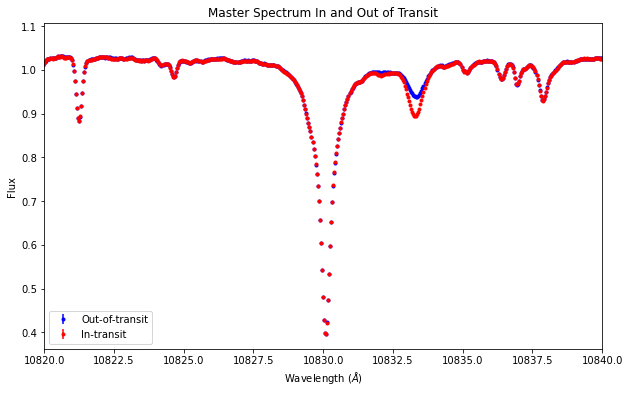

In [15]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    #Plotting the master spectra 

    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, master_outtransit_HA, yerr = master_err_outtransit_HA, fmt='b.', label='Out-of-transit')
    plt.errorbar(ref_wave, master_planet_intransit_HA, yerr = master_err_intransit_HA, fmt='r.', label='In-transit')
    plt.legend()
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Master Spectrum In and Out of Transit for HA')
    plt.xlim([10820, 10840])
    plt.show()

    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, master_outtransit_HE, yerr = master_err_outtransit_HE, fmt='b.', label='Out-of-transit')
    plt.errorbar(ref_wave, master_planet_intransit_HE, yerr = master_err_intransit_HE, fmt='r.', label='In-transit')
    plt.legend()
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Master Spectrum In and Out of Transit for HE')
    plt.xlim([10820, 10840])
    plt.show()

#If there is one mode of observation
else:
    
    #Plotting the master spectra 

    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, master_outtransit, yerr = master_err_outtransit, fmt='b.', label='Out-of-transit')
    plt.errorbar(ref_wave, master_planet_intransit, yerr = master_err_intransit, fmt='r.', label='In-transit')
    plt.legend()
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Master Spectrum In and Out of Transit')
    plt.xlim([10820, 10840])
    plt.show()


## Retrieving the planetary parameters once again

In [16]:
reload(AF)

##Defining the difference between the in-transit and master out-of-transit spectra to get 
#a time series of the planet's spectrum
offset = 1

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    #Initiating arrays to contain the values and error of the planetary absorption spectrum.
    diff_HA = np.ones(planet_in_transit_spctr_HA.shape)
    diff_HA_err = np.ones(planet_in_transit_err_HA.shape)
    
    #Populating the above defined arrays.
    #We add an offset of 1 for later fitting purposes.
    for i in range(len(planet_in_transit_spctr_HA)):
        diff_HA[i] = offset+(master_outtransit_HA - planet_in_transit_spctr_HA[i])/master_outtransit_HA
        diff_HA_err[i] = np.sqrt((planet_in_transit_err_HA[i]/master_outtransit_HA)**2 + ((planet_in_transit_spctr_HA[i] * master_err_outtransit_HA)/(master_outtransit_HA**2))**2)
        #diff_HA_err[i] = diff_HA[i] * np.sqrt((planet_in_transit_err_HA[i]/planet_in_transit_spctr_HA[i])**2 + (master_err_outtransit_HA/master_outtransit_HA)**2)
        #diff_HA_err[i] = np.sqrt(((master_outtransit_HA**2 * planet_in_transit_err_HA[i]**2)+(planet_in_transit_spctr_HA[i]**2 * master_err_outtransit_HA**2))/master_outtransit_HA**4)

    diff_HE = np.ones(planet_in_transit_spctr_HE.shape)
    diff_HE_err = np.ones(planet_in_transit_err_HE.shape)
    for i in range(len(planet_in_transit_spctr_HE)):
        diff_HE[i] = offset+(master_outtransit_HE - planet_in_transit_spctr_HE[i])/master_outtransit_HE
        diff_HE_err[i] = np.sqrt((planet_in_transit_err_HE[i]/master_outtransit_HE)**2 + ((planet_in_transit_spctr_HE[i] * master_err_outtransit_HE)/(master_outtransit_HE**2))**2)

#If there is one mode of observation
else:
    
    #Initiating arrays to contain the values and error of the planetary absorption spectrum.
    diff = np.ones(planet_in_transit_spctr.shape)
    diff_err = np.ones(planet_in_transit_err.shape)
    
    #Populating the above defined arrays.
    #We add an offset of 1 for later fitting purposes.
    for i in range(len(planet_in_transit_spctr)):
        diff[i] = offset+(master_outtransit - planet_in_transit_spctr[i])/master_outtransit
        diff_err[i] = np.sqrt((planet_in_transit_err[i]/master_outtransit)**2 + ((planet_in_transit_spctr[i] * master_err_outtransit)/(master_outtransit**2))**2)



/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.16591845e+04 -4.91509120e+14  7.00587316e-06]


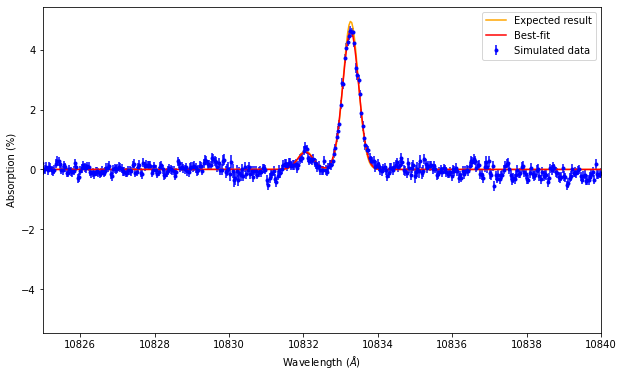

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.22339067e+04 -5.06189473e+14  5.93683251e-04]


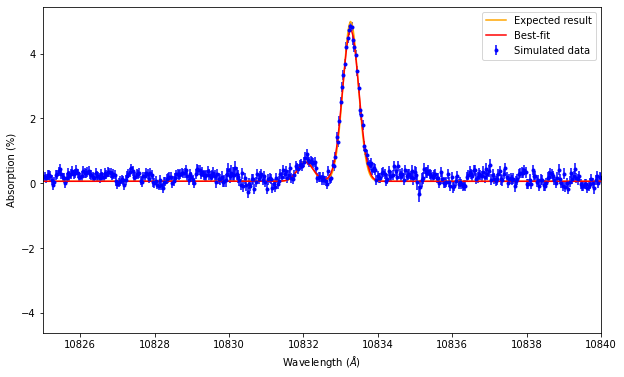

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01614664e+04 -4.88233170e+14 -2.65529098e-04]


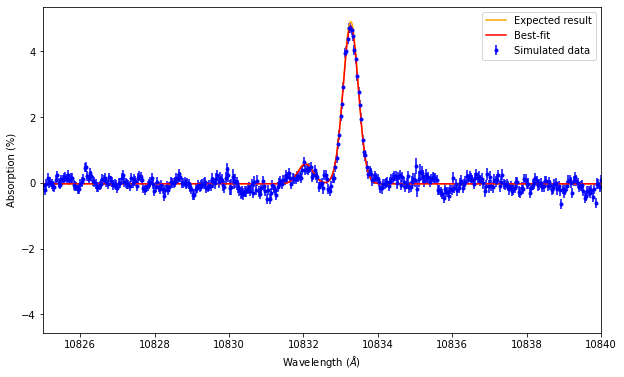

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06114513e+04 -4.82685272e+14 -4.91568080e-04]


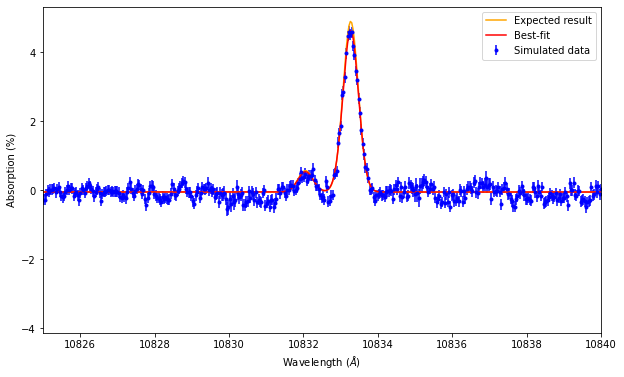

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.21382549e+04 -5.21130668e+14  1.53909785e-03]


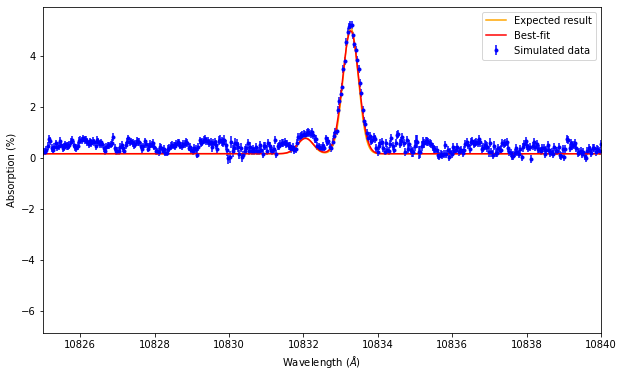

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15192725e+04 -5.14487622e+14  4.50378377e-04]


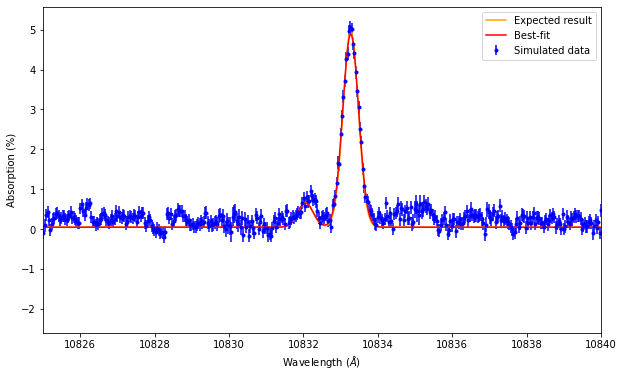

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14309391e+04 -5.08876056e+14  2.96180053e-04]


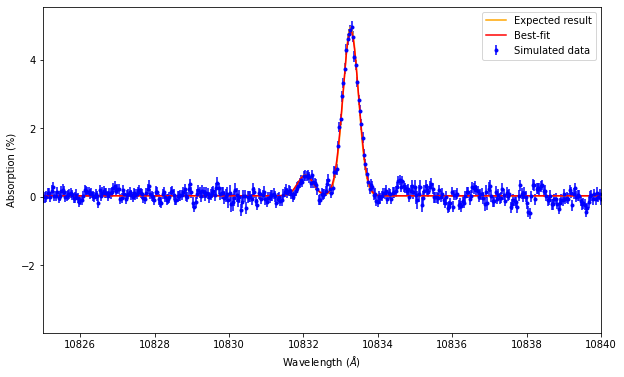

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14102469e+04 -5.12538363e+14 -8.45410707e-04]


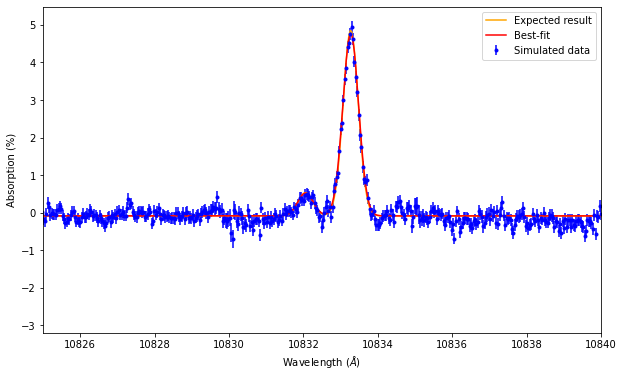

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10149683e+04 -4.96735881e+14  1.33220692e-03]


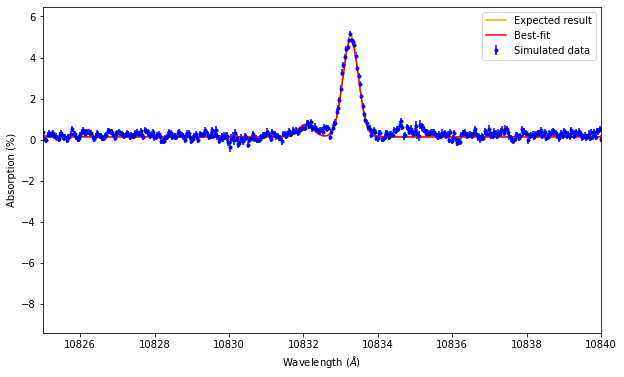

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05373509e+04 -4.96009526e+14  5.83842741e-04]


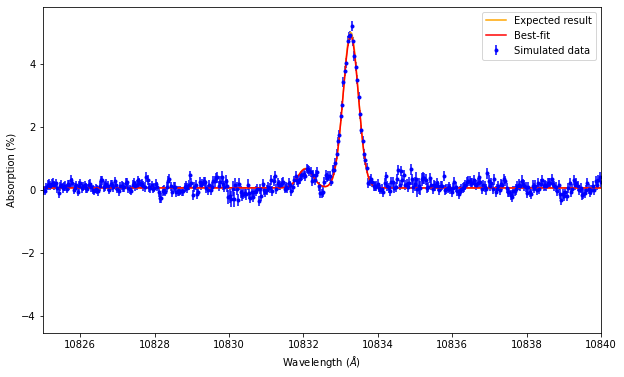

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01898143e+04 -4.74632562e+14 -1.12999556e-03]


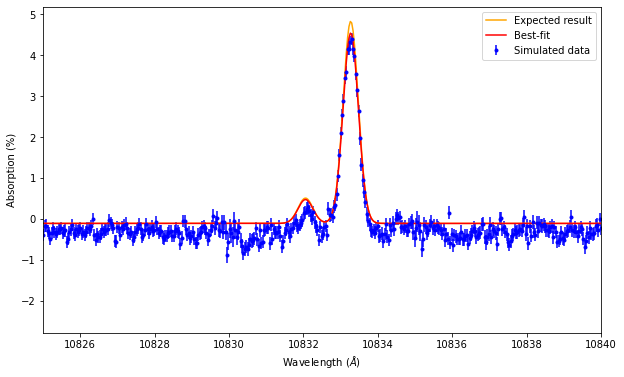

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05947032e+04 -4.83768895e+14  1.93855115e-03]


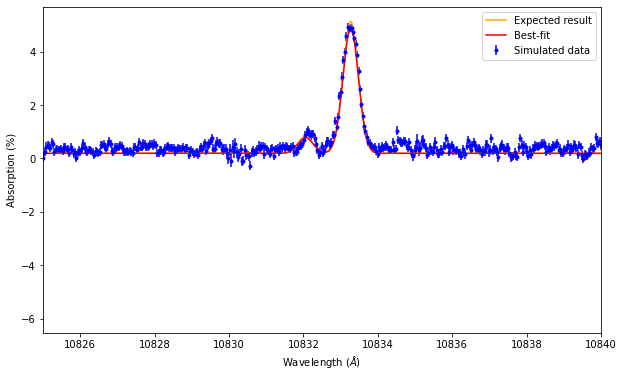

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11574975e+04 -5.04986572e+14 -1.62477651e-03]


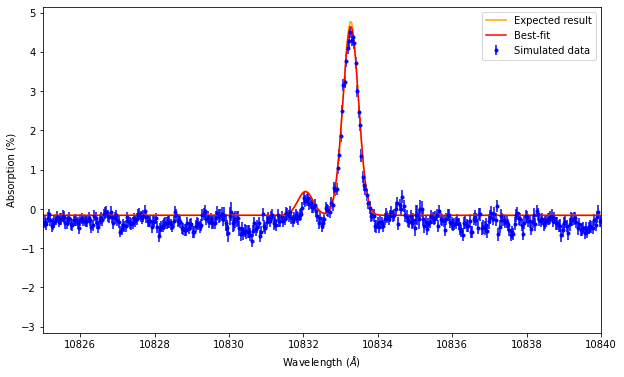

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02119243e+04 -4.87109648e+14  1.37554247e-03]


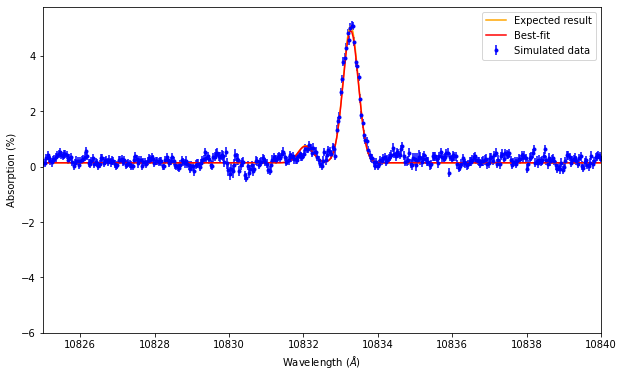

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04308901e+04 -4.90576647e+14 -5.96313773e-05]


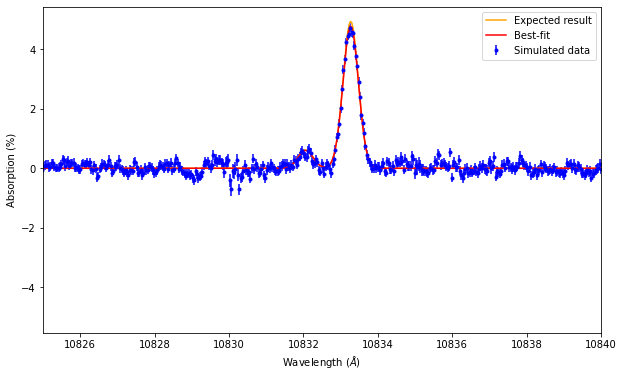

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06853104e+04 -4.82645831e+14 -1.00493321e-03]


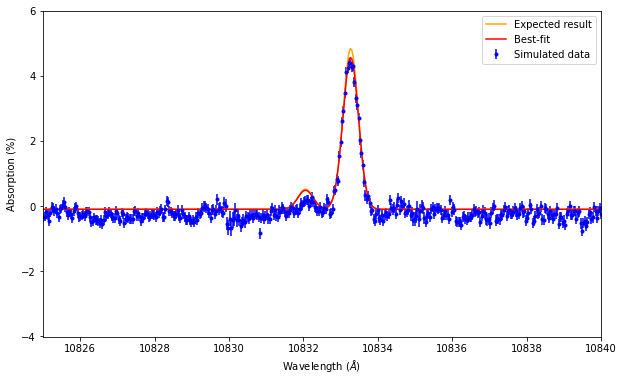

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05796691e+04 -4.84068062e+14 -8.61465274e-04]


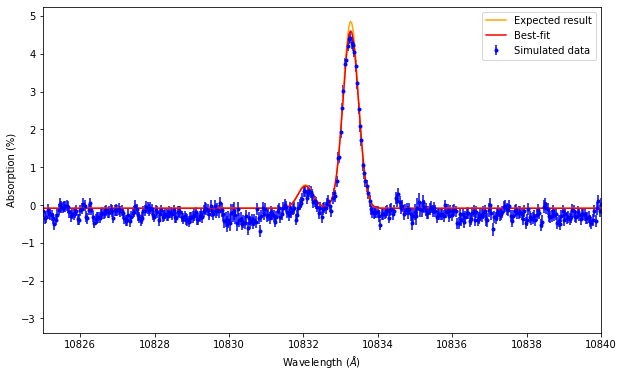

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.18271880e+04 -5.16322105e+14 -5.11071411e-04]


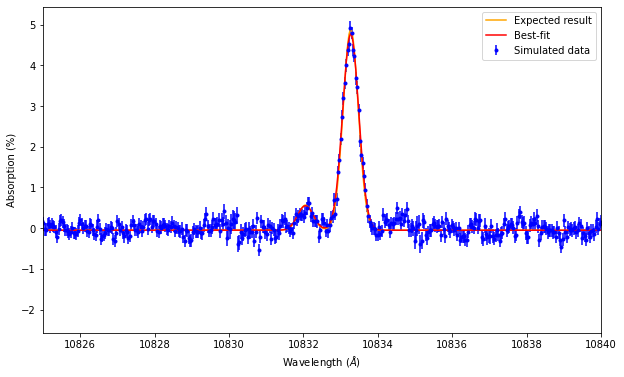

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.23571624e+04 -5.22393809e+14 -2.31325128e-04]


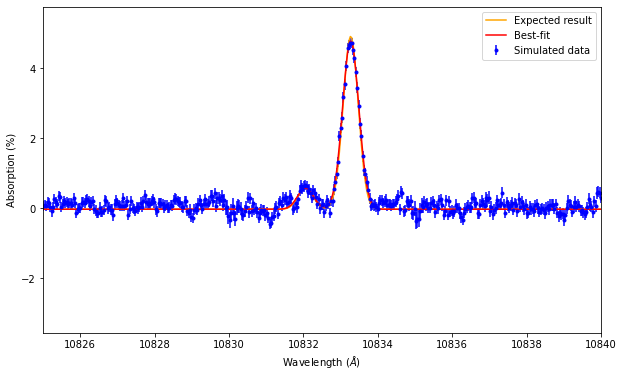

[ 1.30813067e+04 -5.33617517e+14  6.14840007e-04]


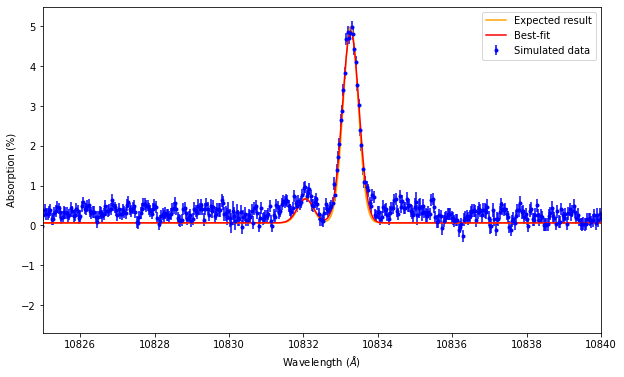

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14591857e+04 -5.18466777e+14  1.09665234e-03]


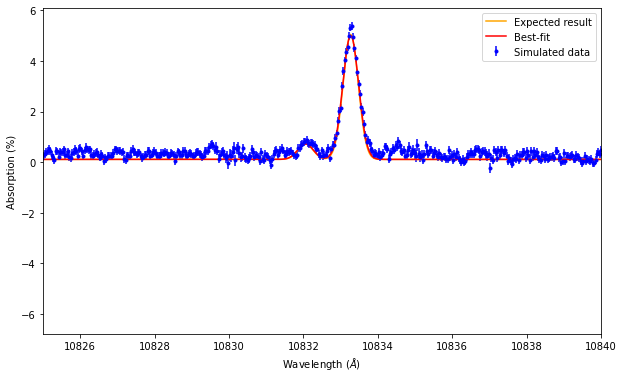

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17501233e+04 -5.19660167e+14 -3.66014915e-04]


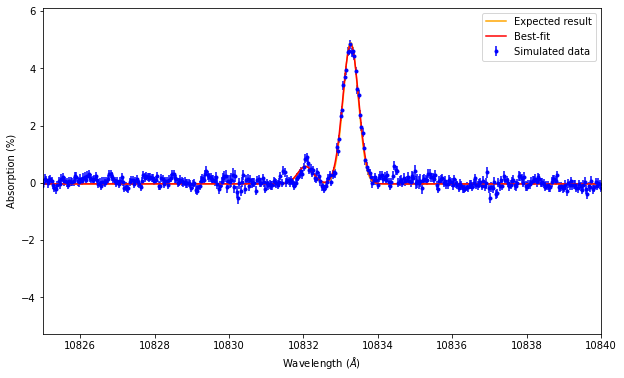

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.82168074e+03 -4.86774624e+14 -3.71557631e-04]


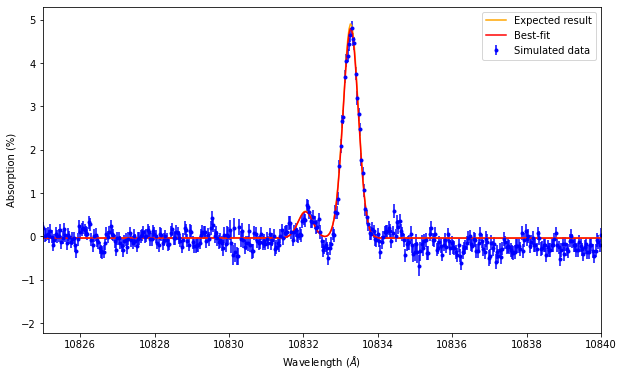

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08606231e+04 -4.96715410e+14 -1.29208666e-04]


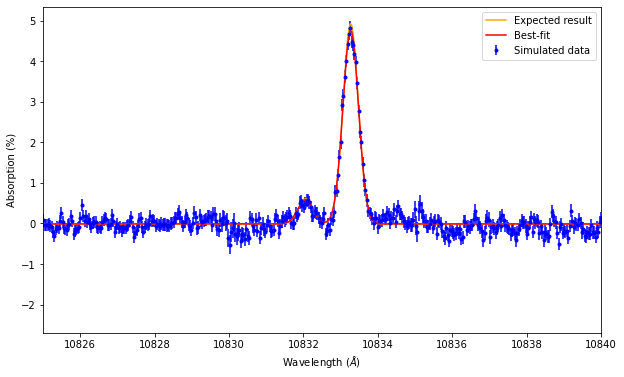

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.19872046e+04 -5.14462009e+14  2.31216410e-03]


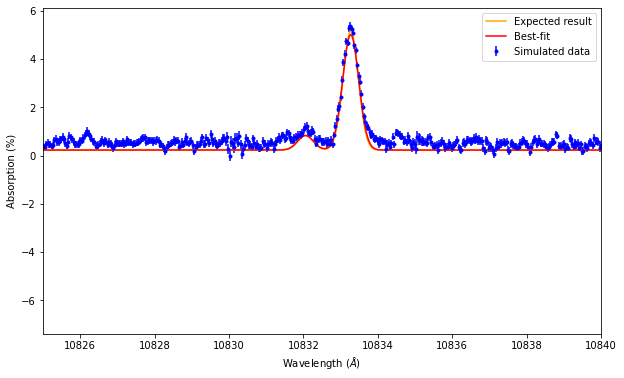

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04306011e+04 -4.83067347e+14 -1.43433472e-03]


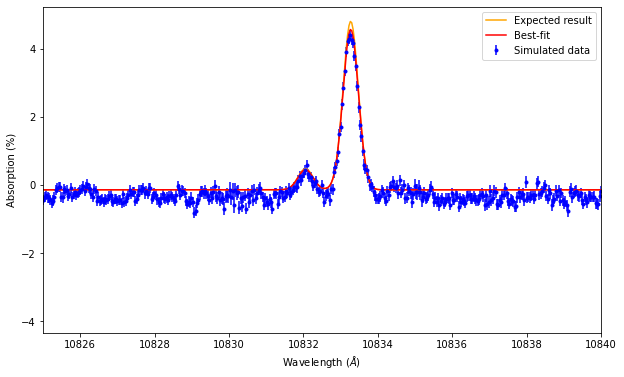

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09351780e+04 -5.00756170e+14  8.84483077e-04]


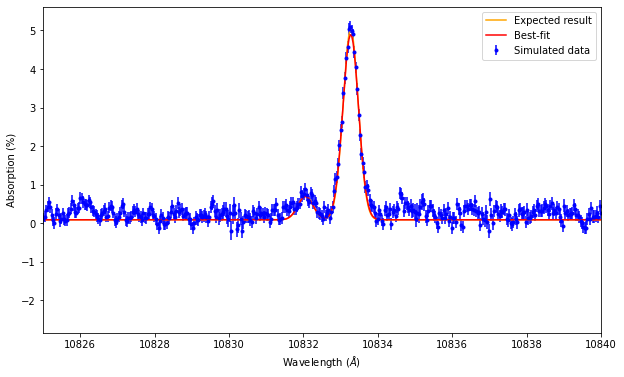

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.69069445e+03 -4.72655365e+14 -1.36178511e-03]


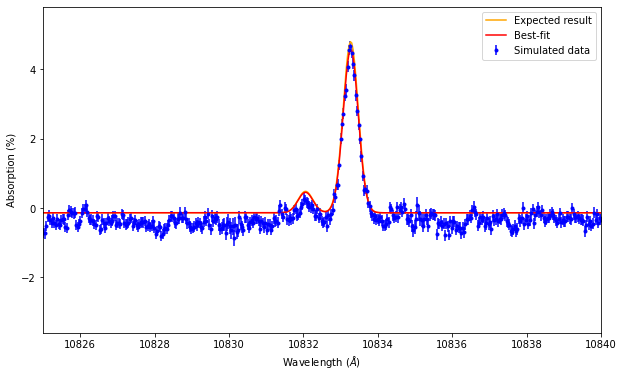

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14322204e+04 -4.98869444e+14 -1.12978950e-03]


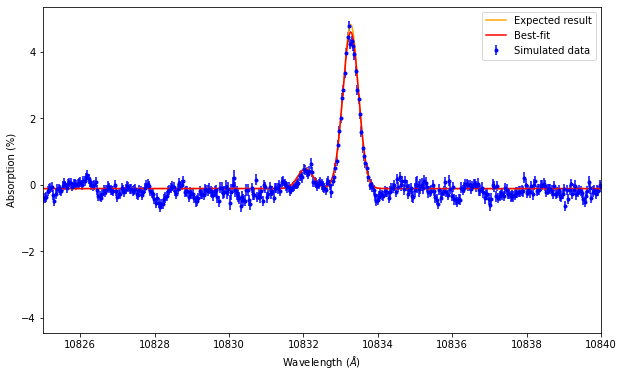

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11925685e+04 -5.11635047e+14  1.21109219e-03]


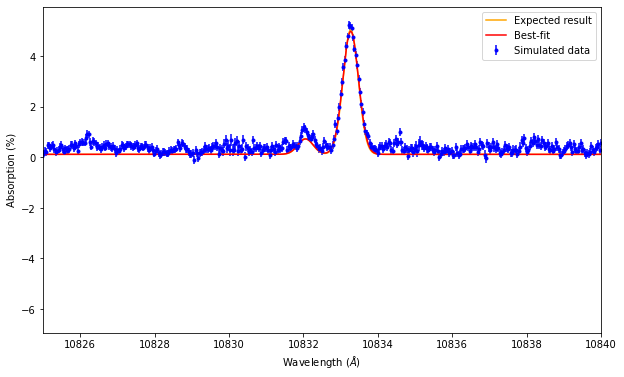

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09133286e+04 -4.85656393e+14 -4.01779179e-04]


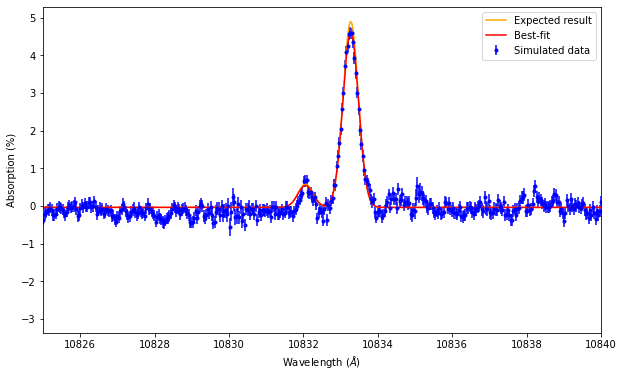

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02078792e+04 -4.82408760e+14  2.75445059e-04]


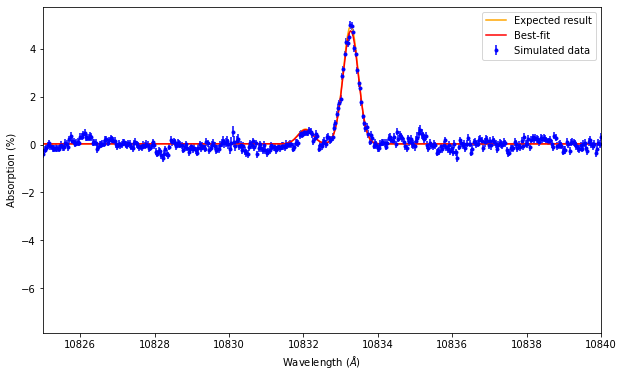

[ 1.30079659e+04 -5.21984151e+14  2.40114545e-03]


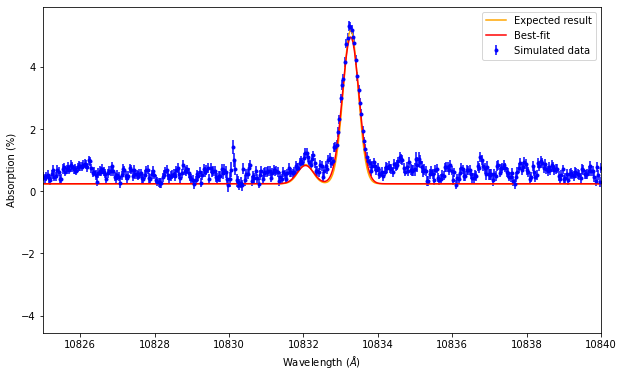

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.23497768e+04 -5.05840419e+14  5.77319738e-04]


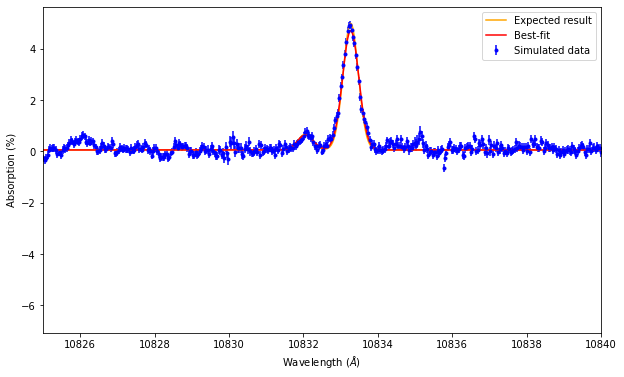

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07927985e+04 -4.96078777e+14 -5.81234896e-04]


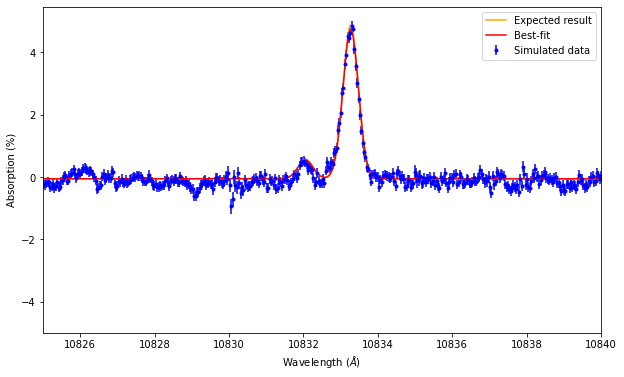

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14478210e+04 -4.94461773e+14 -3.93180794e-04]


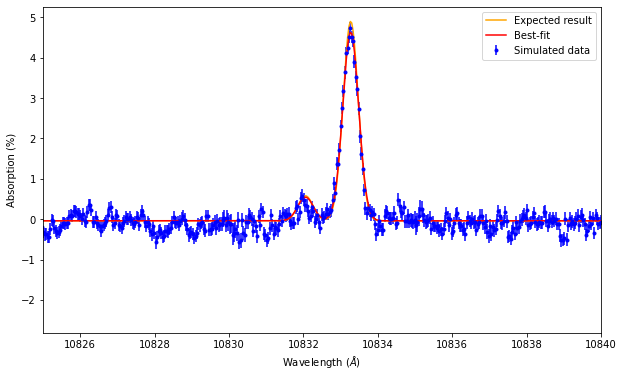

[ 1.34435170e+04 -5.28637382e+14  7.90669827e-04]


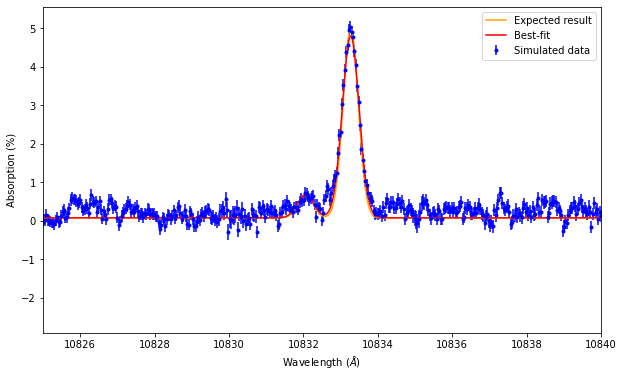

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.16318414e+04 -5.08331407e+14  5.47549480e-04]


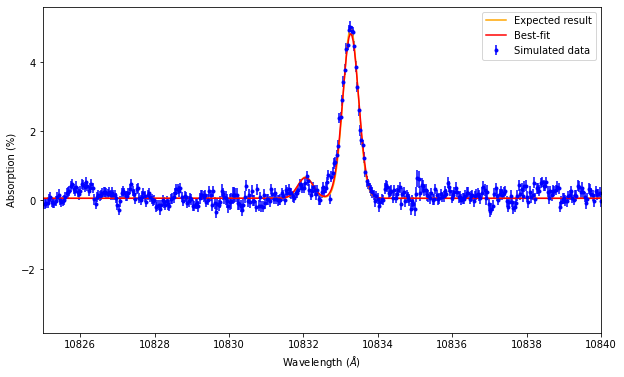

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.20809141e+04 -5.05646153e+14 -3.74561737e-04]


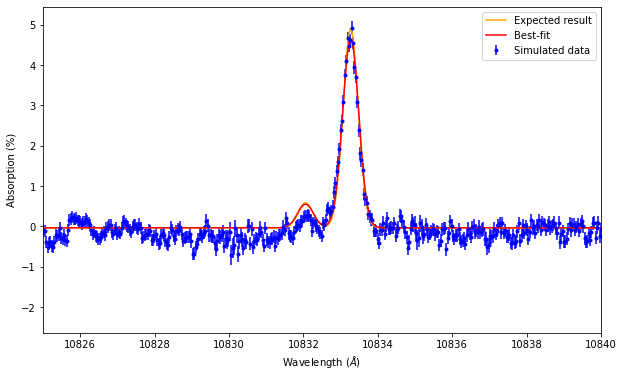

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17630540e+04 -5.20975121e+14 -2.32764218e-04]


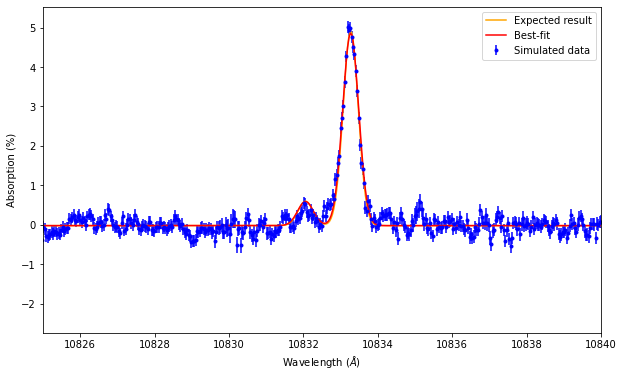

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.57029638e+03 -4.66773610e+14  6.75590966e-05]


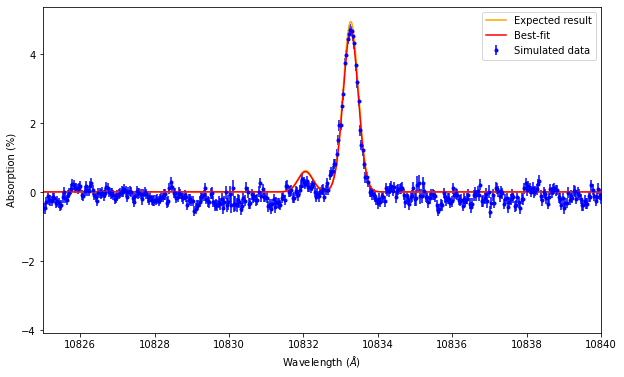

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.89204154e+03 -4.73543858e+14 -8.38299925e-04]


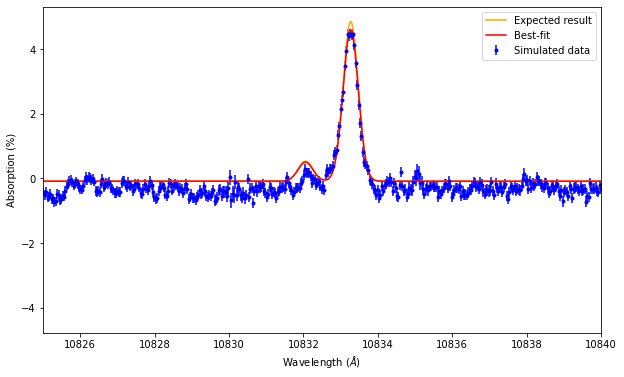

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.96906474e+03 -4.62756565e+14 -1.28159278e-03]


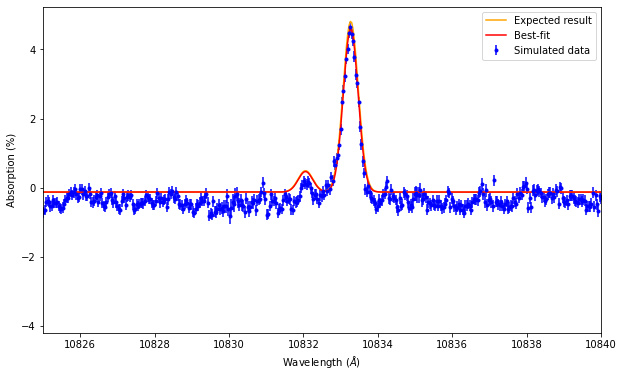

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05034366e+04 -5.00344044e+14  4.55404259e-04]


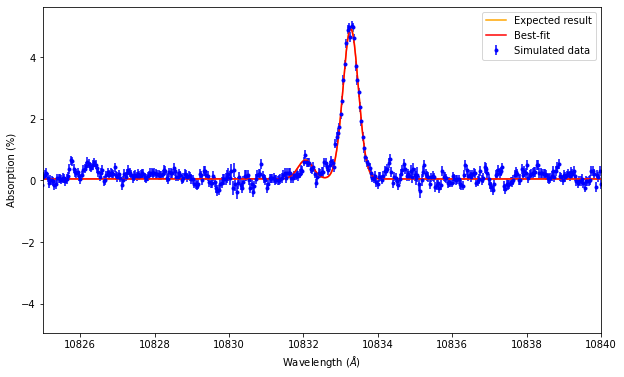

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14583529e+04 -5.09631197e+14 -3.11467006e-04]


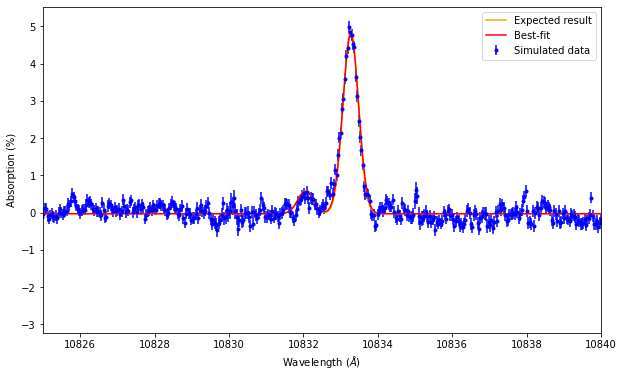

[ 1.32007128e+04 -5.40135278e+14  3.63176431e-03]


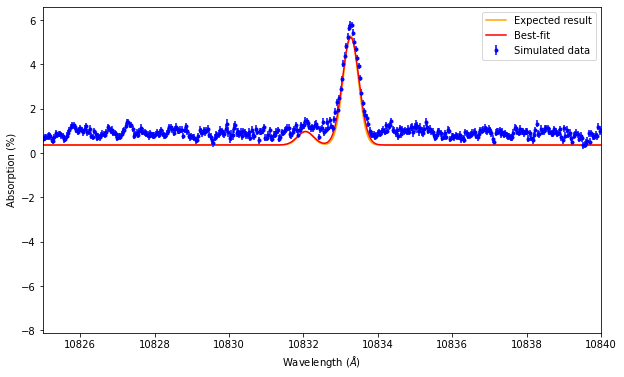

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.50073671e+03 -4.69952514e+14 -5.98906631e-04]


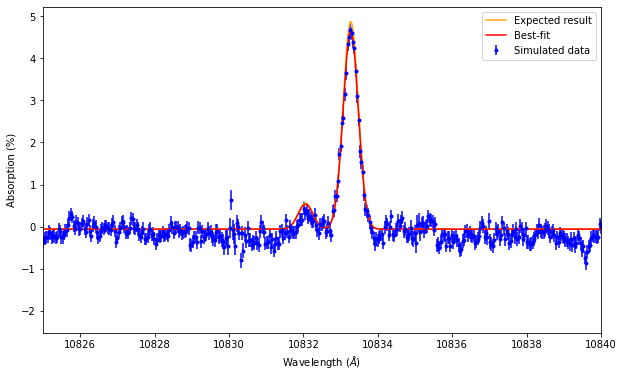

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.12403777e+04 -4.92666935e+14 -1.18262994e-03]


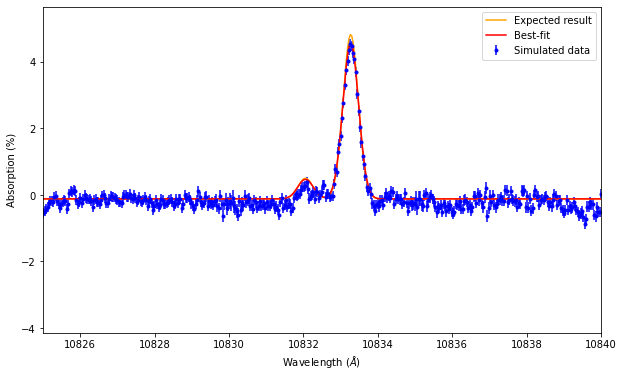

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03947295e+04 -4.72556645e+14  3.98365215e-04]


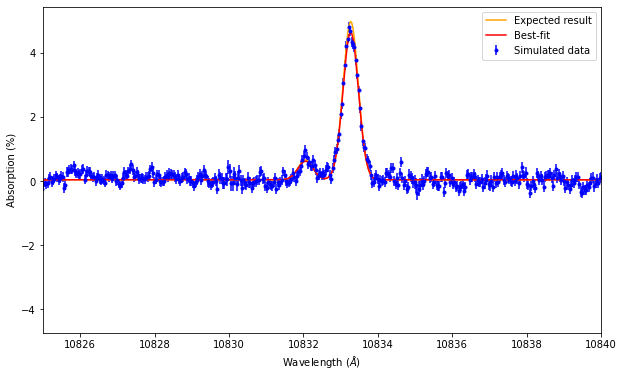

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.19923595e+04 -5.18254408e+14  1.55570763e-03]


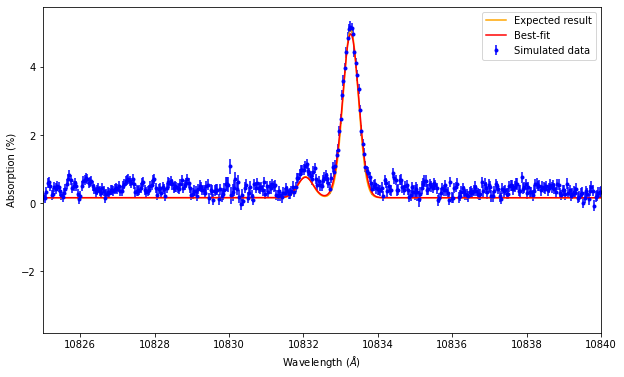

[ 1.51017105e+04 -5.63090480e+14  2.06099185e-03]


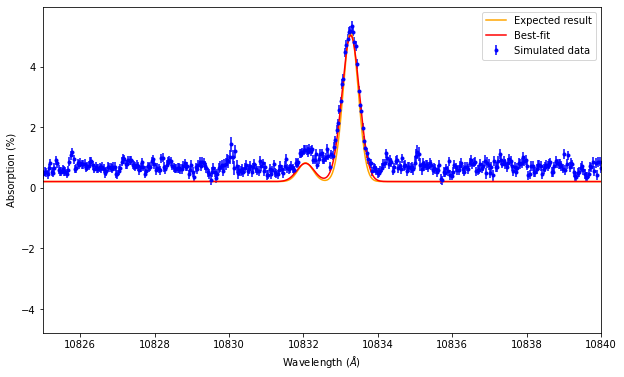

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17303499e+04 -5.05888631e+14  8.48645695e-04]


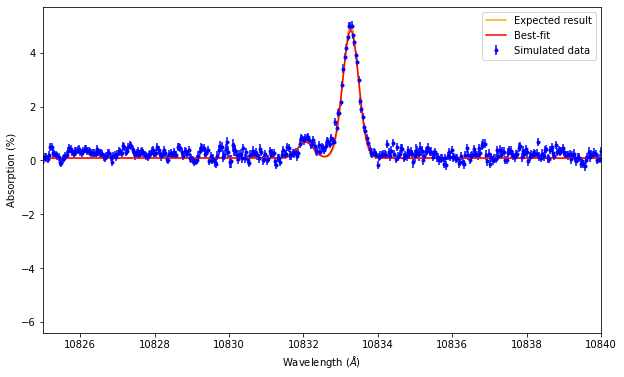

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07012982e+04 -4.80988697e+14  3.72528689e-04]


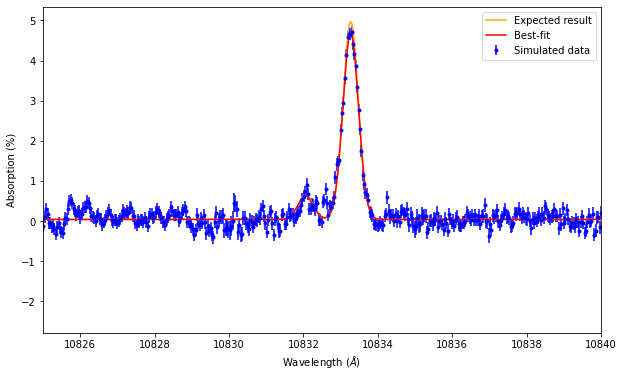

[ 1.20981148e+04 -5.26238709e+14  1.17631315e-04]


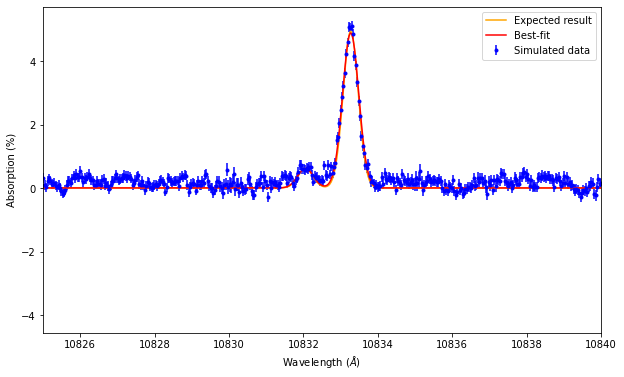

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14479416e+04 -5.07563838e+14  1.79601510e-03]


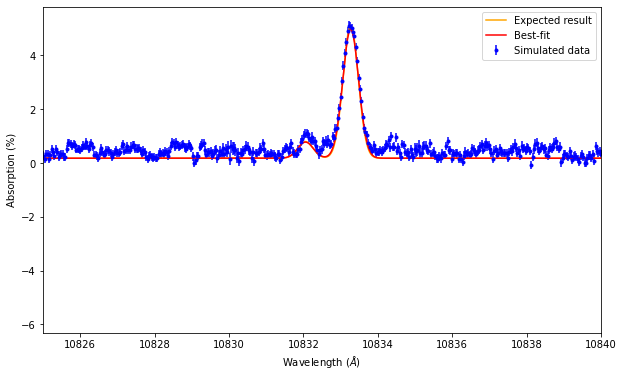

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.23763036e+03 -4.80324025e+14 -2.16824606e-03]


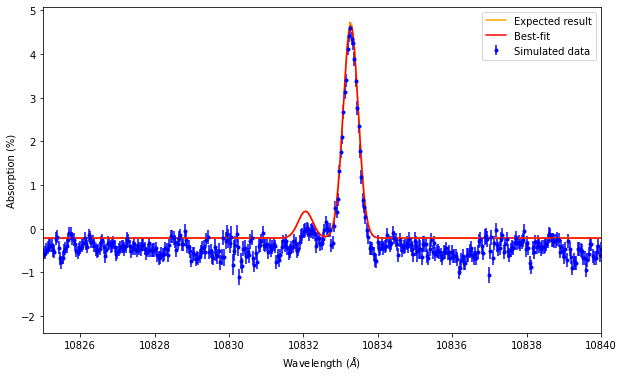

[ 1.20602531e+04 -5.15053369e+14  9.50317791e-04]


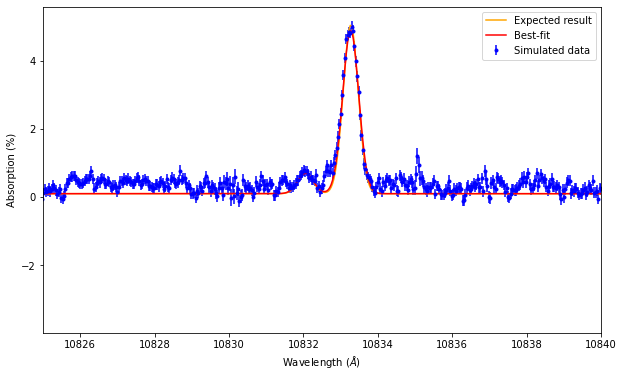

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.59273703e+03 -4.76514255e+14 -1.54644012e-04]


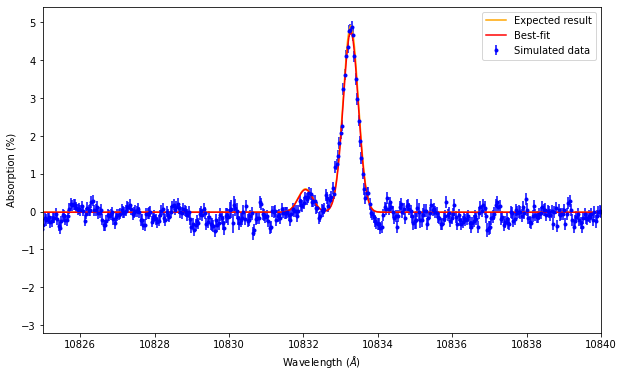

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02967581e+04 -4.97448411e+14  4.16441747e-04]


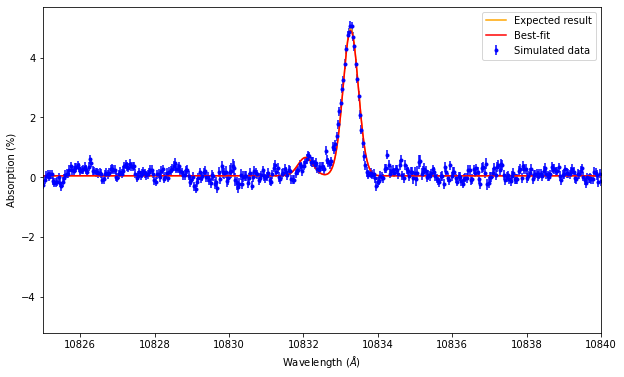

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.18677252e+04 -5.19813945e+14 -6.36903808e-04]


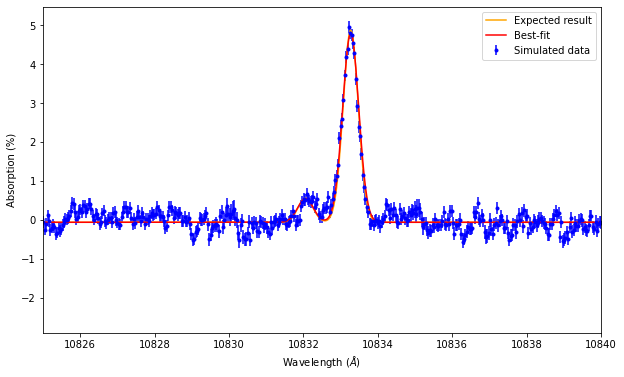

[ 1.22090922e+04 -5.03941795e+14 -2.22342797e-04]


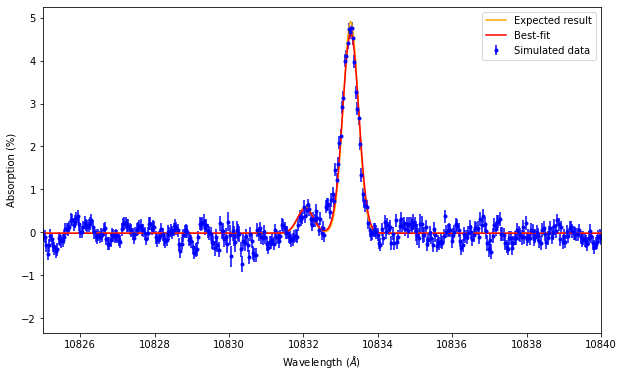

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11990156e+04 -5.08406603e+14 -1.27928300e-03]


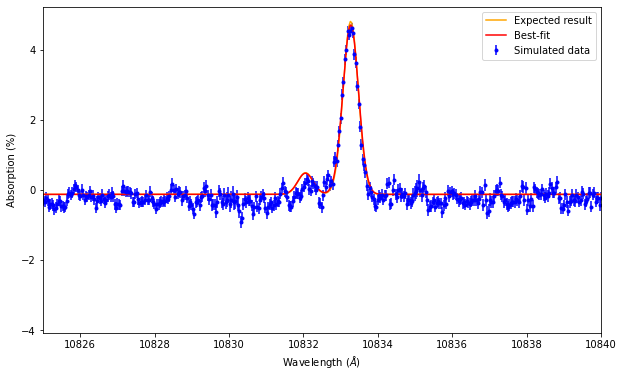

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11711241e+04 -5.01768910e+14 -1.76264049e-03]


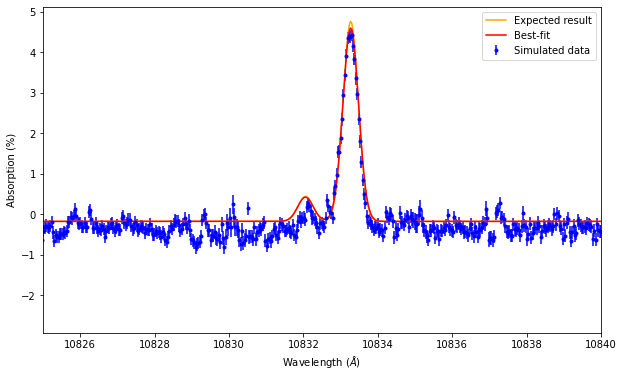

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.20525036e+04 -5.12153047e+14  1.19383274e-03]


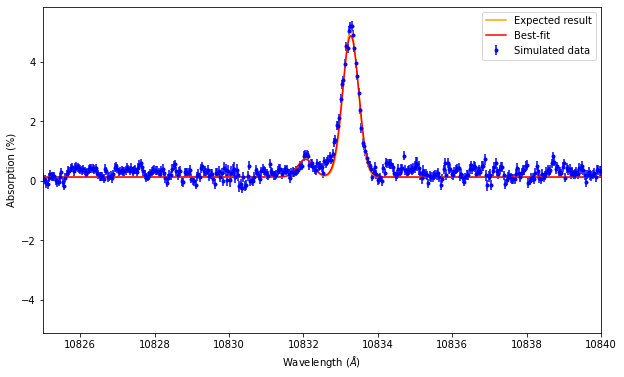

[ 1.28736108e+04 -5.15835245e+14  9.24334878e-04]


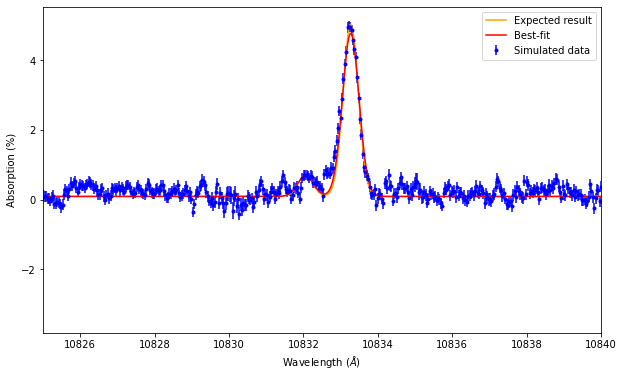

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04624358e+04 -4.85019937e+14  5.54524446e-04]


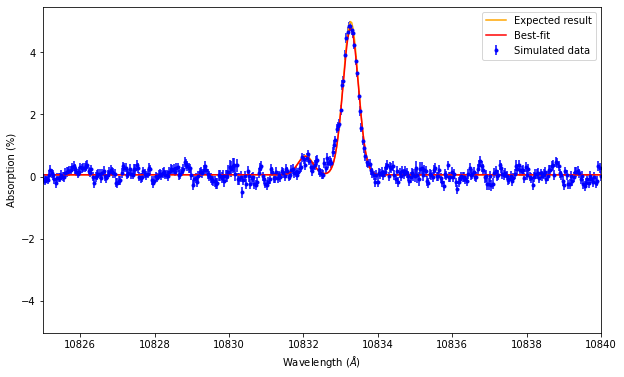

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03991247e+04 -4.87519231e+14 -1.49097151e-05]


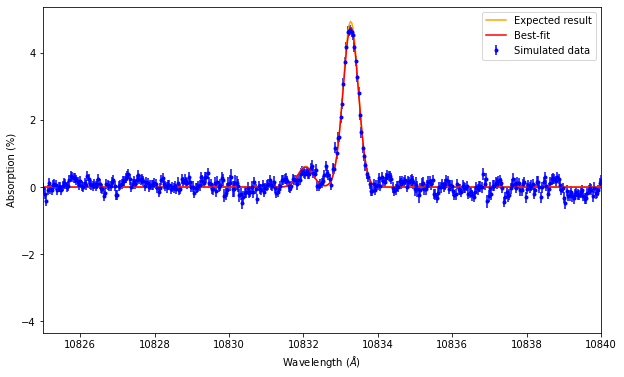

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.99888749e+03 -4.70812256e+14 -9.26494503e-04]


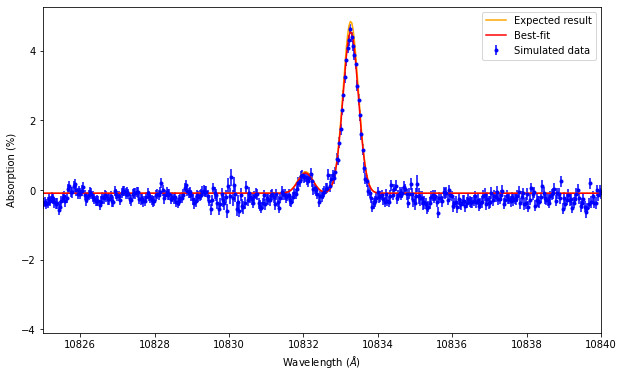

[ 1.25073022e+04 -5.29427044e+14 -3.39286149e-04]


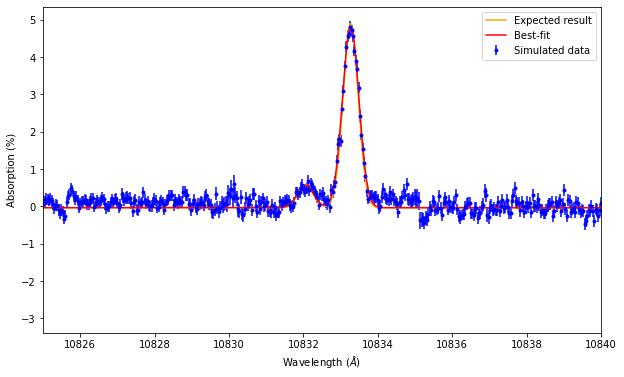

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.21827978e+03 -4.73225711e+14 -1.44623767e-03]


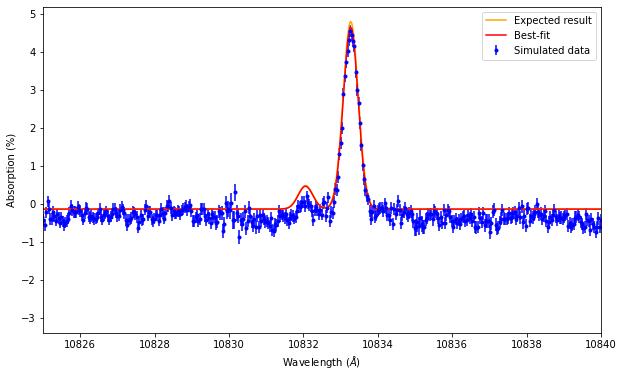

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10181572e+04 -5.04596472e+14  2.89911923e-04]


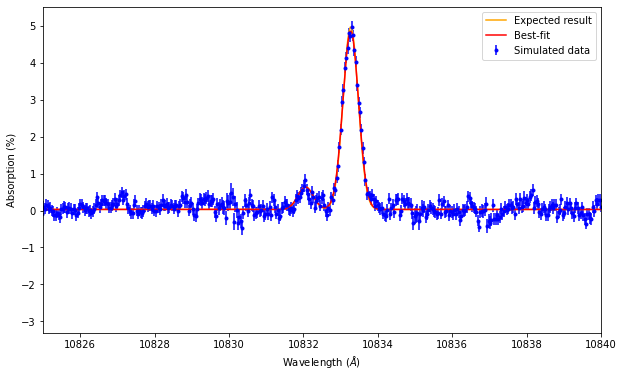

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.04467824e+03 -4.69875019e+14 -2.77335663e-03]


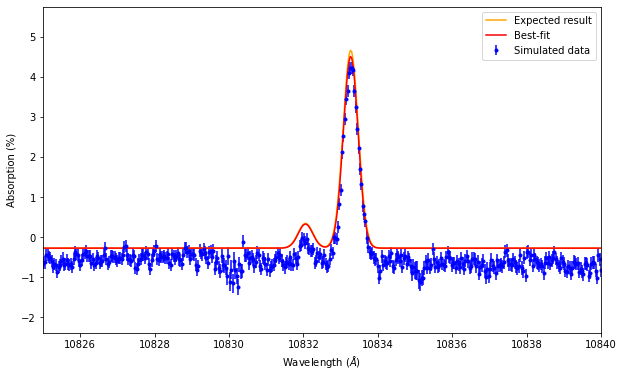

[ 1.24625230e+04 -5.47078846e+14  9.42061141e-05]


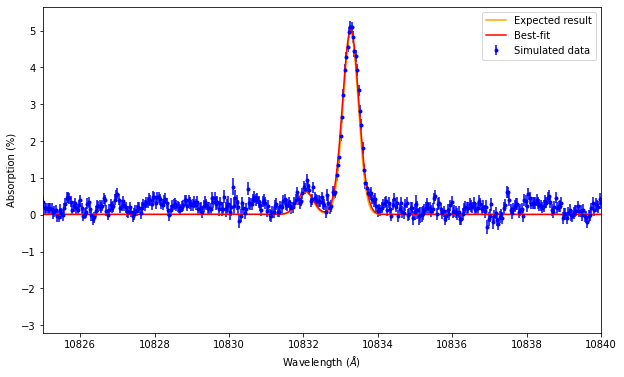

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04462971e+04 -4.94044337e+14  4.89228915e-04]


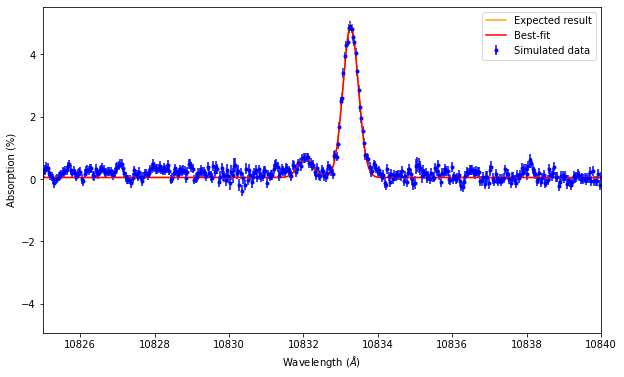

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.01776639e+03 -4.69478351e+14  2.00851101e-05]


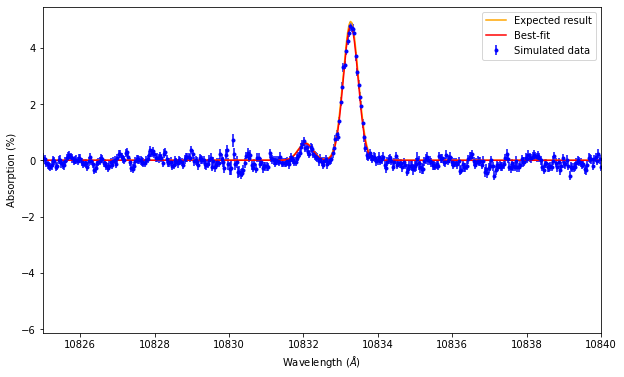

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04149400e+04 -5.03614496e+14 -3.75582630e-05]


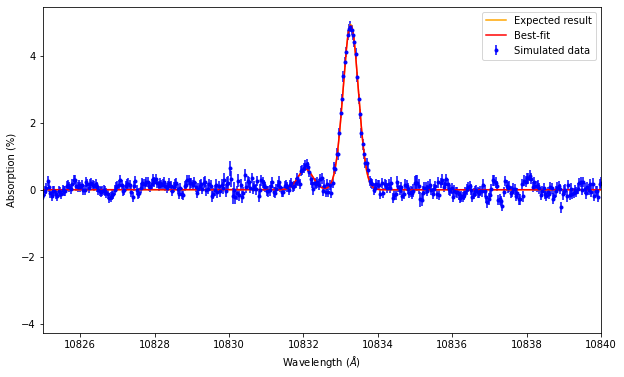

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.92897623e+03 -4.63462854e+14 -9.00405638e-04]


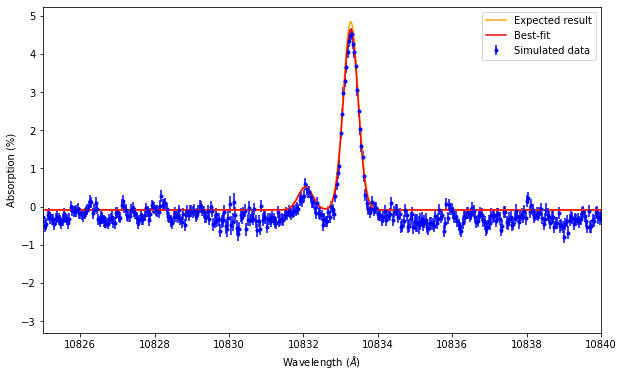

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.86632913e+03 -4.94059722e+14 -1.27413853e-03]


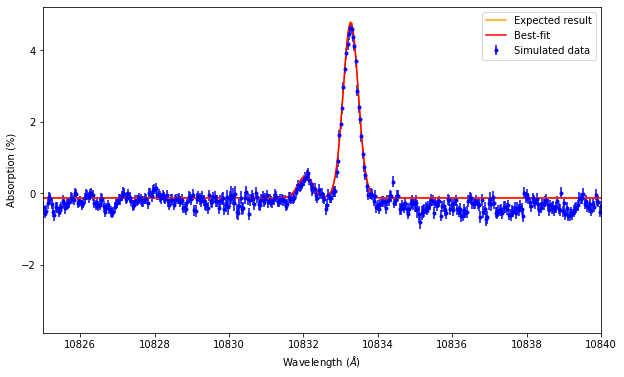

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.16867774e+03 -4.75669766e+14 -3.33890560e-04]


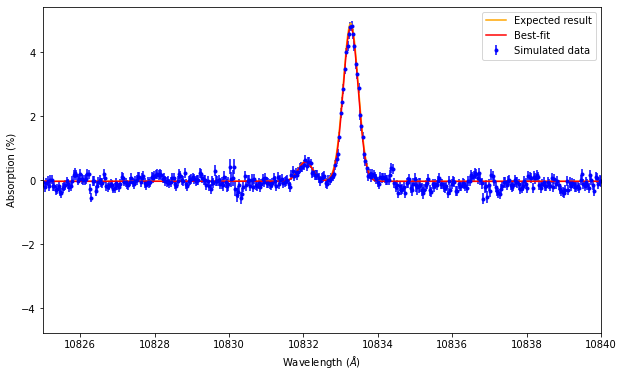

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.93268447e+03 -4.83594322e+14 -2.14201857e-03]


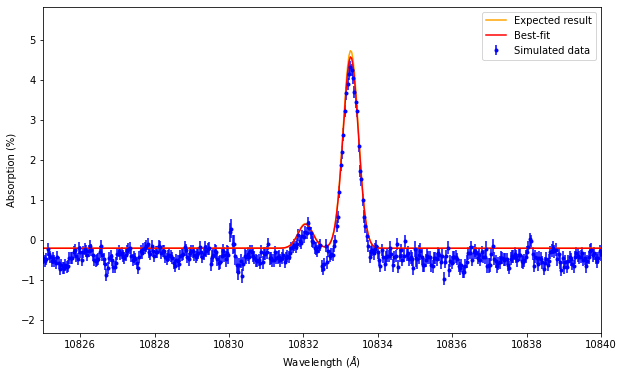

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.26785854e+03 -4.68808460e+14 -6.10247062e-04]


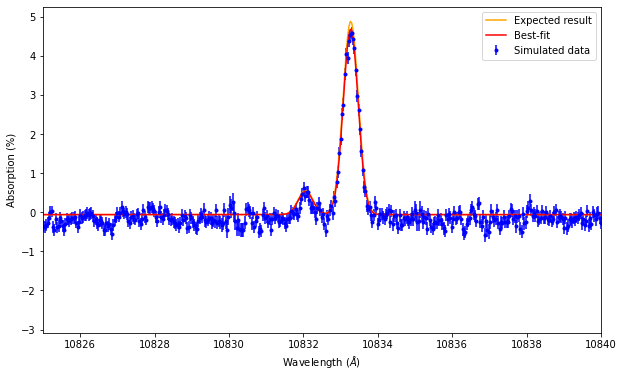

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.12154169e+04 -5.08142907e+14  1.76129449e-03]


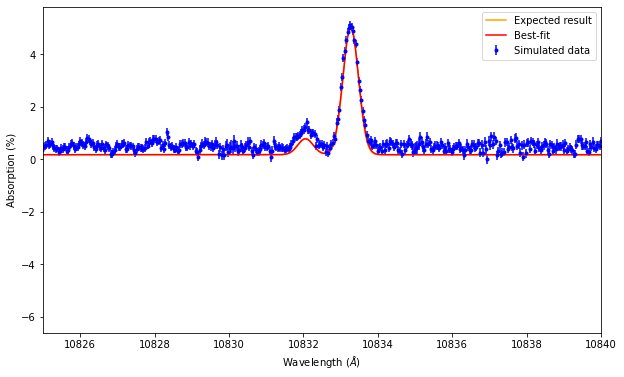

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.31600879e+03 -4.84974642e+14  1.51199692e-03]


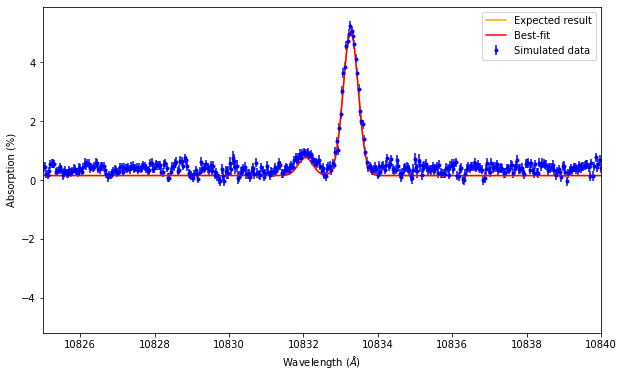

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.19914322e+04 -5.17530078e+14  1.29154739e-03]


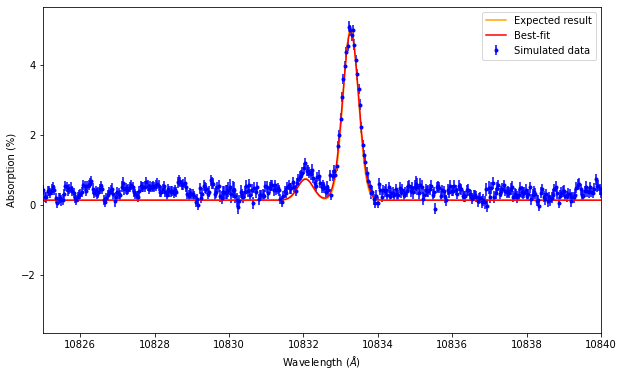

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.97157865e+03 -4.76895522e+14 -1.05334432e-03]


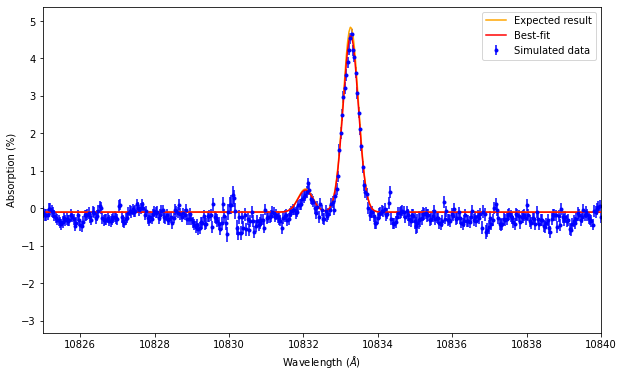

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.71057935e+03 -4.94143746e+14  8.87367203e-04]


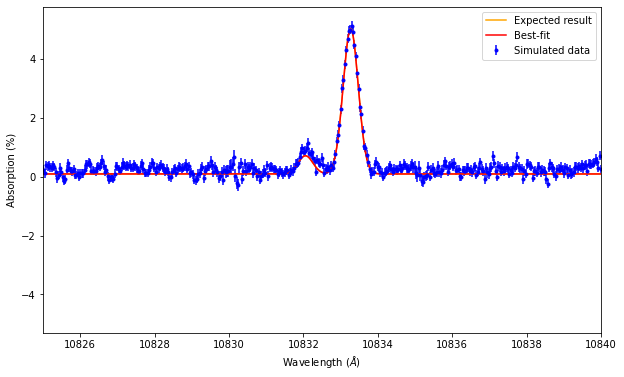

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05000069e+04 -4.98133656e+14 -1.44482944e-03]


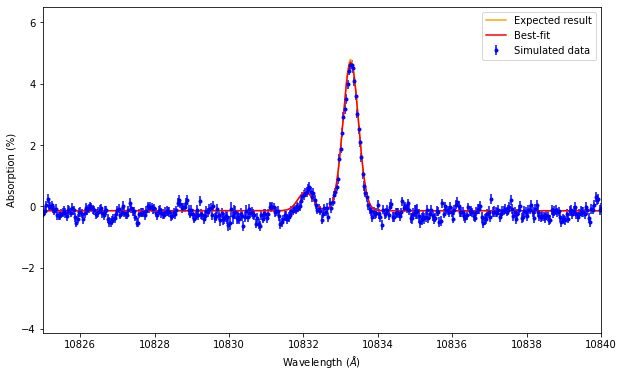

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02550829e+04 -4.88996393e+14 -7.72901696e-04]


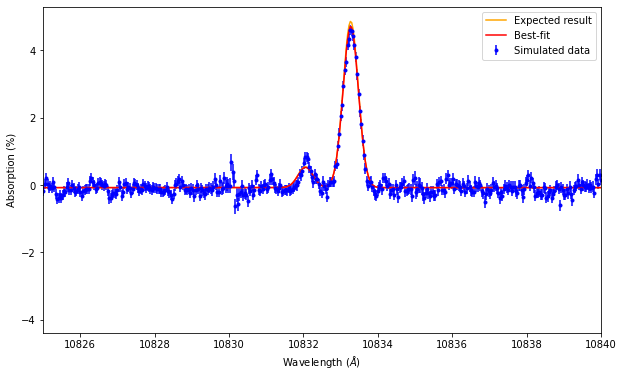

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.84651227e+03 -4.83368735e+14 -1.07520316e-03]


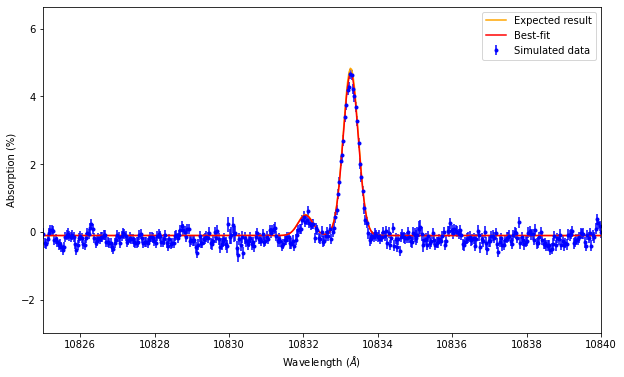

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04918471e+04 -5.14963394e+14 -5.06753183e-04]


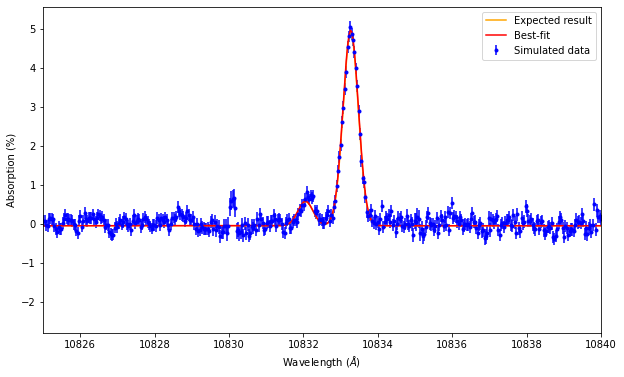

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.41099694e+03 -4.76509729e+14 -7.42534155e-04]


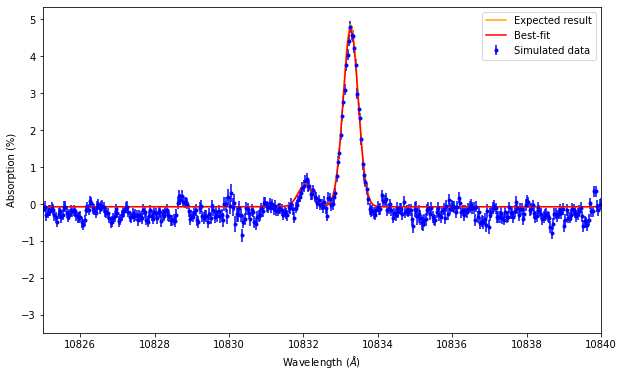

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.00025025e+04 -4.94465916e+14 -3.15501047e-04]


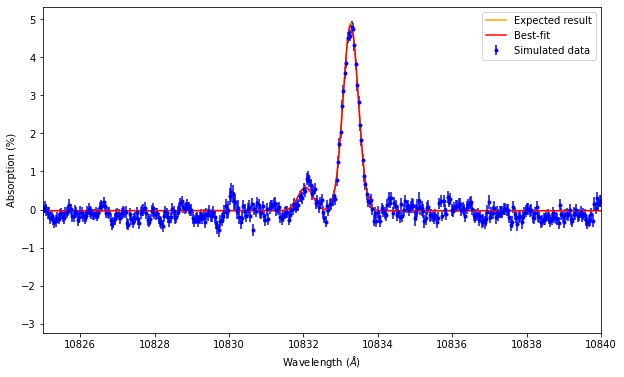

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.18051134e+03 -4.68978494e+14 -2.41713146e-03]


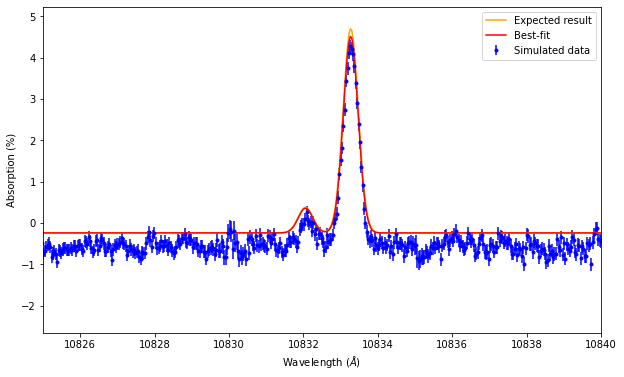

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01679228e+04 -4.81355653e+14  7.81386316e-04]


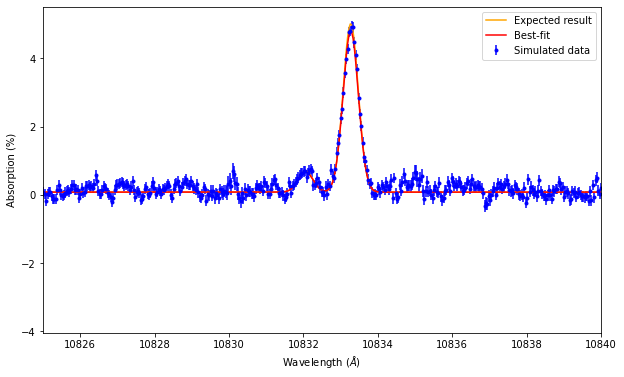

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.05212098e+03 -4.64293555e+14 -5.19948811e-04]


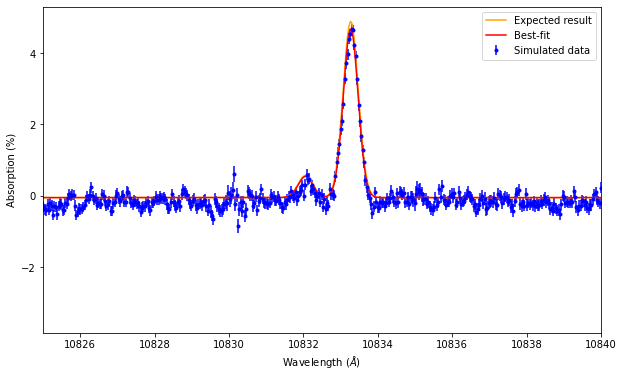

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.16487597e+04 -5.25351620e+14  1.31388690e-03]


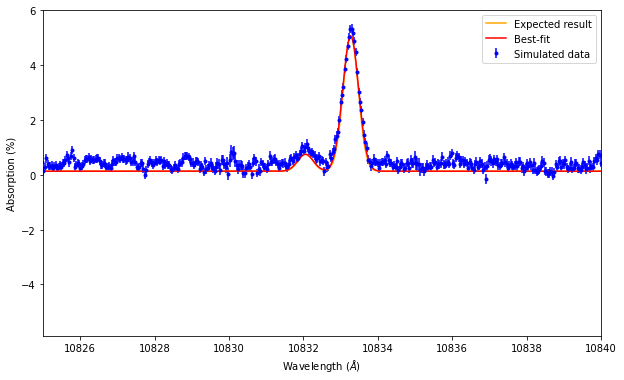

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08414700e+04 -5.08594664e+14  1.18415703e-03]


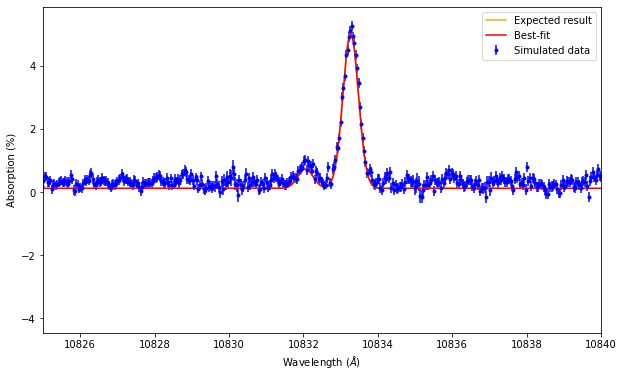

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04244005e+04 -5.03017287e+14 -1.31439469e-03]


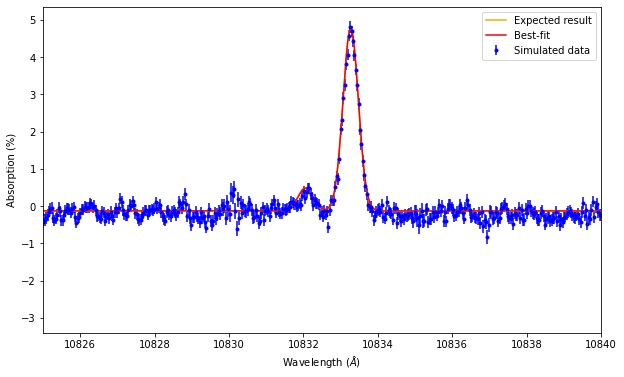

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.55435950e+03 -4.76020577e+14  1.33320691e-04]


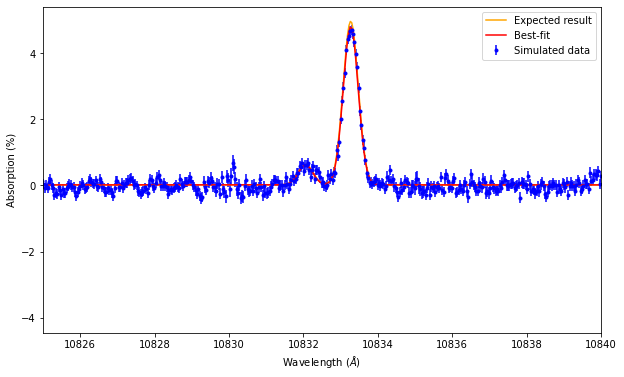

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.75412572e+03 -4.77941603e+14  3.80824842e-05]


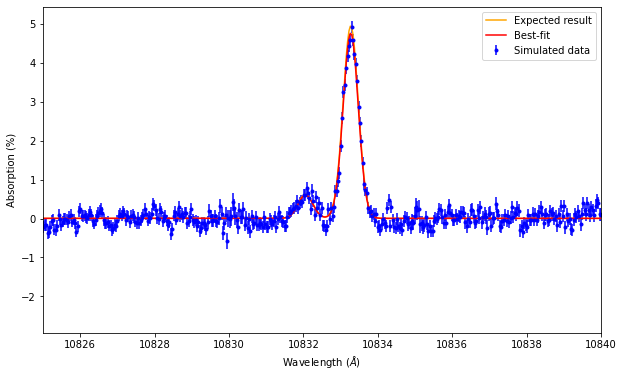

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.21611849e+04 -5.19937777e+14  5.21420567e-04]


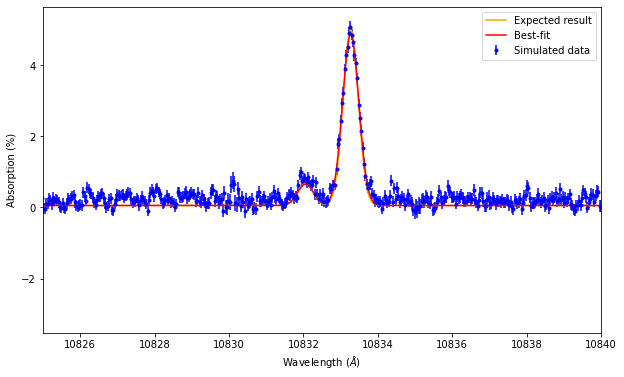

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04205973e+04 -4.96239689e+14  1.00461879e-03]


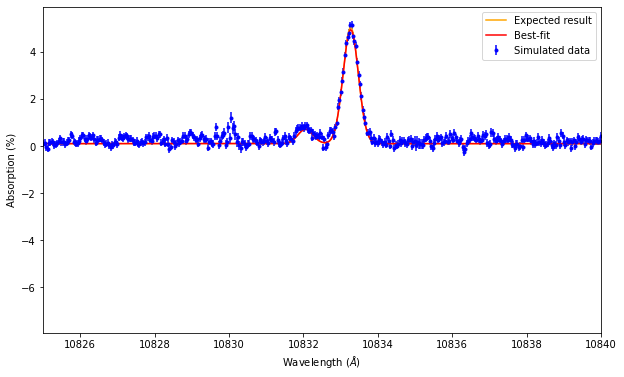

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.98968621e+03 -4.95219644e+14 -7.60876787e-04]


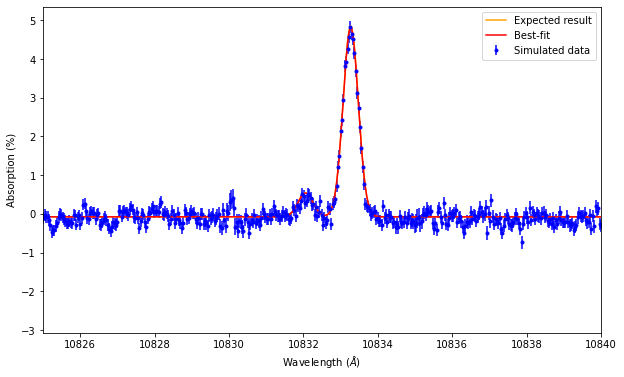

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.15825916e+03 -4.80363122e+14  3.93598003e-04]


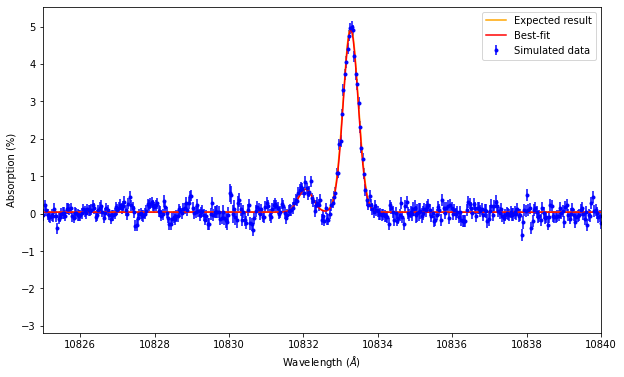

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13256096e+04 -5.20185884e+14  2.49488526e-03]


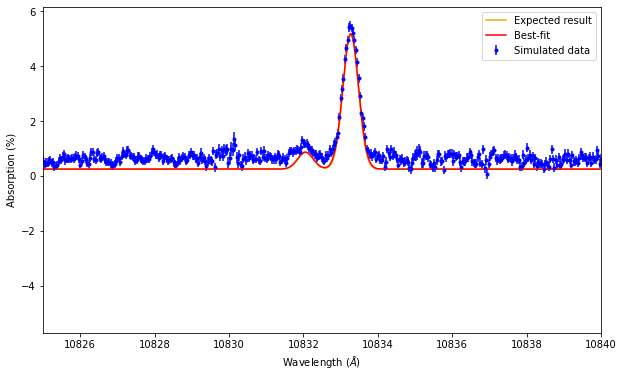

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.90651630e+03 -4.83886472e+14 -2.36926489e-03]


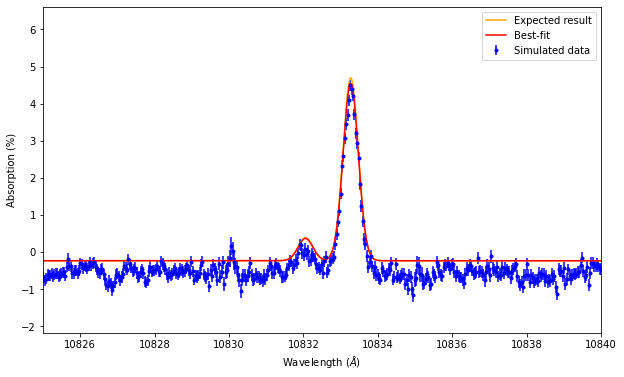

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06209872e+04 -4.97096187e+14  1.34669165e-04]


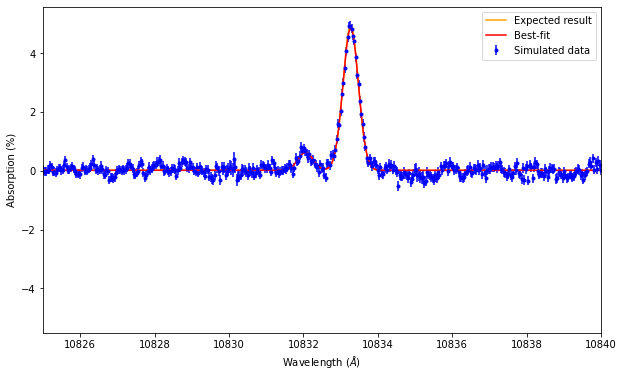

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01451305e+04 -5.06948772e+14 -5.11925736e-04]


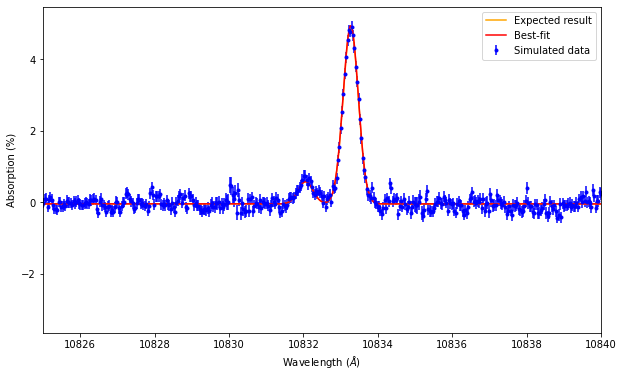

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.52162656e+03 -4.84032988e+14  1.39864903e-03]


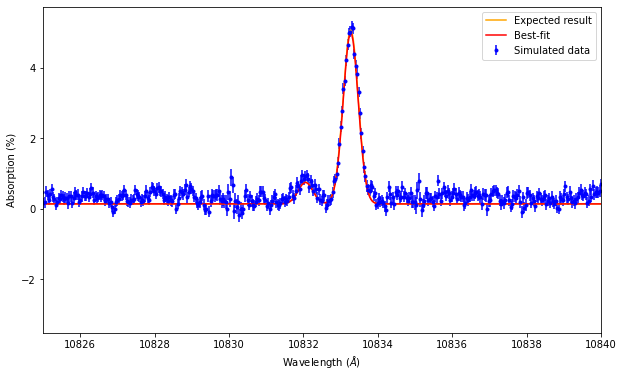

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04484751e+04 -4.92840441e+14  2.44548618e-03]


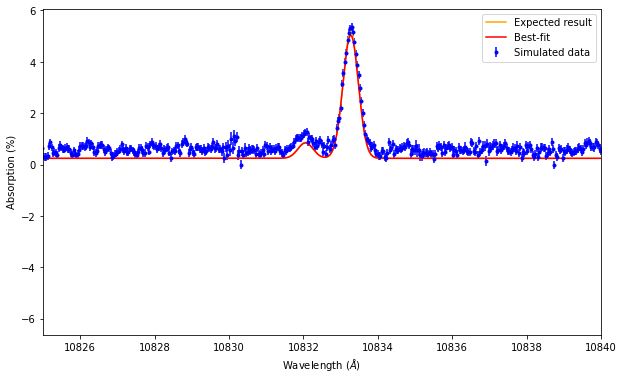

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.68197302e+03 -4.76896397e+14 -1.96515705e-04]


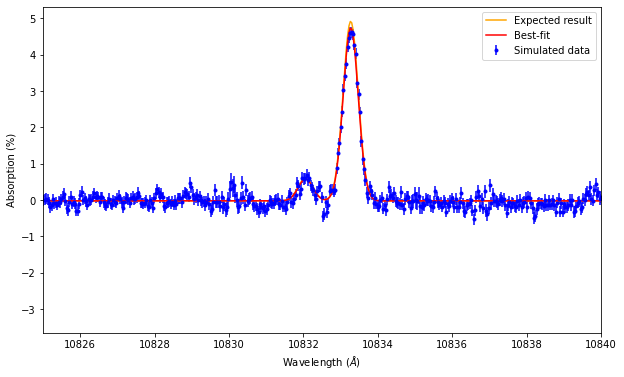

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.38040488e+03 -4.74420383e+14 -1.90355251e-04]


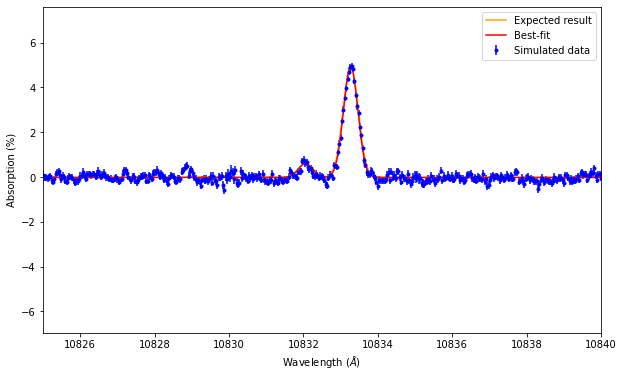

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.62291438e+03 -4.62863323e+14 -4.49963861e-04]


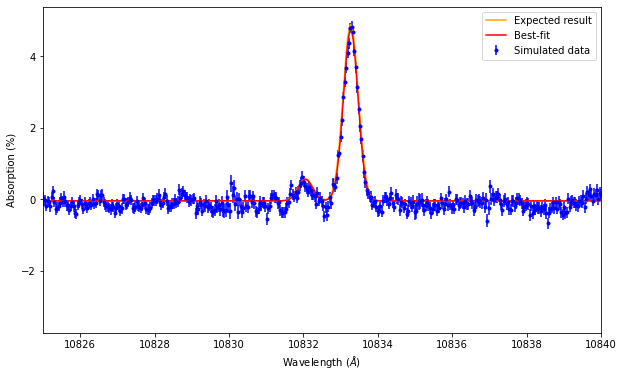

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09083485e+04 -4.97784574e+14 -1.38607135e-03]


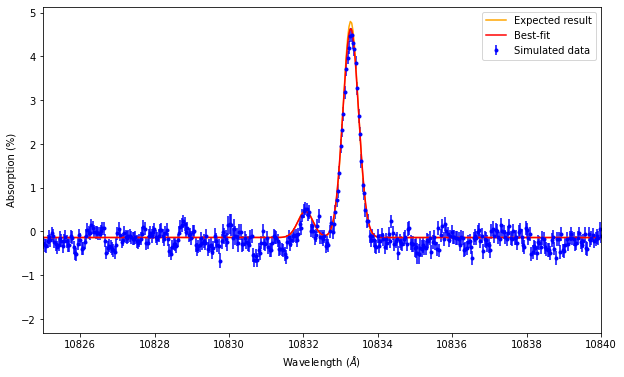

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17996730e+04 -5.20505586e+14 -5.61192612e-04]


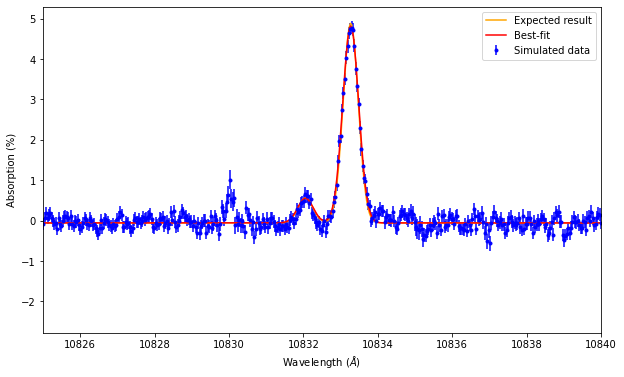

In [17]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    #Re-defining the absorption function
    #We fix the stellar velocity because the Sun's velocity is well known.
    #We fit for the atmospheric He column density and the temperature of the atmosphere.
    def absorption_function_HA(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_HA[0].shape), temp, density, vsini, 'VACUUM', R_pow = R_power_HA)

    def absorption_function_HE(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_HE[0].shape), temp, density, vsini, 'VACUUM', R_pow = R_power_HE)

    #Creating arrays to store the best-fit parameters and the error on them
    param_HA = np.zeros((len(diff_HA), 3))
    err_HA = np.zeros((len(diff_HA), 3))

    param_HE = np.zeros((len(diff_HE), 3))
    err_HE = np.zeros((len(diff_HE), 3))

    #Iterating over the time series to get a value of the retrieved parameters for each spectrum
    for i in range(len(diff_HA)):
        #Guess on the initial parameters
        guess = [16000, 1e14, np.median(diff_HA[i])]

        #Chi-squared minimization routine
        params, cov = curve_fit(absorption_function_HA, ref_wave, diff_HA[i], sigma = diff_HA_err[i], p0=guess)

        #Storing the best-fit parameters and errors
        param_HA[i] = params
        err_HA[i] = np.sqrt(np.diag(cov))

        #Plotting the in-transit planetary spectra and their corresponding model
        print(params)
        plt.figure(figsize=[10, 6])
        model = absorption_function_HA(ref_wave, params[0], params[1], params[2])
        plt.errorbar(ref_wave, 100*(diff_HA[i]-1+params[2]), yerr=100*diff_HA_err[i], fmt='b.', label='Simulated data')
        plt.plot(ref_wave, 100*(absorption_function_HA(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
        plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
        plt.xlim([10825, 10840])
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Absorption (%)')
        plt.legend()
        plt.show()
        
    for i in range(len(diff_HE)):
        #Guess on the initial parameters
        guess = [16000, 1e14, np.median(diff_HE[i])-1]
        print(np.median(diff_HE[i])-1)
        #Chi-squared minimization routine
        params, cov = curve_fit(absorption_function_HE, ref_wave, diff_HE[i], sigma=diff_HE_err[i], p0=guess)

        #Storing the best-fit parameters and errors
        param_HE[i] = params
        err_HE[i] = np.sqrt(np.diag(cov))

        #Plotting the in-transit planetary spectra and their corresponding model
        print(params)
        plt.figure(figsize=[10, 6])
        model = absorption_function_HE(ref_wave, params[0], params[1], params[2])
        plt.errorbar(ref_wave, 100*(diff_HE[i]-1+params[2]), yerr = 100*diff_HE_err[i], fmt='b.', label='Simulated data')
        plt.plot(ref_wave, 100*(absorption_function_HE(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
        plt.plot(ref_wave, 100*(model-1), 'k', label='Best-fit')
        plt.xlim([10825, 10840])
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Absorption (%)')
        plt.legend()
        plt.show()

#If there is one mode of observation
else:
    #Re-defining the absorption function
    #We fix the stellar velocity because the Sun's velocity is well known.
    #We fit for the atmospheric He column density and the temperature of the atmosphere.
    def absorption_function(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff[0].shape), temp, density, vsini, 'VACUUM', R_pow = R_power)

    #Creating arrays to store the best-fit parameters and the error on them
    param = np.zeros((len(diff), 3))
    err = np.zeros((len(diff), 3))
    
   #Iterating over the time series to get a value of the retrieved parameters for each spectrum
    for i in range(len(diff)):

        guess = [16000, 1e14, np.median(diff[i])]
        
        #Chi-squared minimization routine
        params, cov = curve_fit(absorption_function, ref_wave, diff[i], sigma=diff_err[i], p0=guess)

        #Storing the best-fit parameters and errors
        param[i] = params
        err[i] = np.sqrt(np.diag(cov))

        #Plotting the in-transit planetary spectra and their corresponding model
        print(params)
        plt.figure(figsize=[10, 6])
        model = absorption_function(ref_wave, params[0], params[1], params[2])
        plt.errorbar(ref_wave, 100*(diff[i]-1+params[2]), 100*diff_err[i], fmt='b.', label='Simulated data')
        plt.plot(ref_wave, 100*(absorption_function(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
        plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
        plt.xlim([10825, 10840])
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Absorption (%)')
        plt.legend()
        plt.show()


#For fitting purposes, we needed to have negative densities, so we revert to positive values.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    param_HA[:, 1] = -param_HA[:, 1]
    param_HE[:, 1] = -param_HE[:, 1]
#For fitting purposes, we needed to have negative densities, so we revert to positive values.
else:    
    param[:, 1] = -param[:, 1]



## Sanity check fit on the master absorption spectrum

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07166949e+04 -4.96380636e+14  1.03651970e-05]


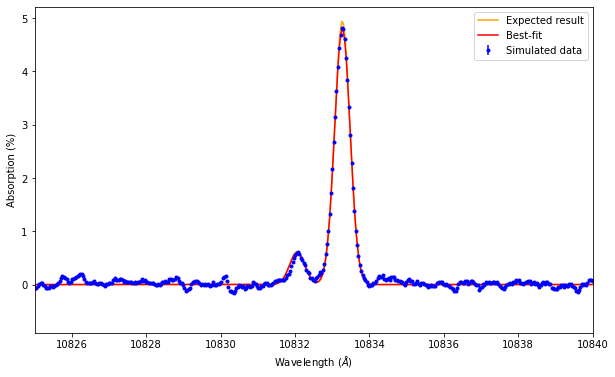

In [18]:

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
        
    diff_master_HA = offset+(master_outtransit_HA - master_planet_intransit_HA)/master_outtransit_HA

    diff_master_err_HA = np.sqrt((master_err_intransit_HA/master_outtransit_HA)**2 + ((master_err_intransit_HA * master_err_outtransit_HA)/(master_outtransit_HA**2))**2)

    def absorption_function(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_master_HA.shape), temp, density, vsini, 'VACUUM', R_pow = R_power_HA)

    guess = [16000, 1e14, np.median(diff_master_HA)]

    #Chi-squared minimization routine
    params, cov = curve_fit(absorption_function, ref_wave, diff_master_HA, sigma=diff_master_err_HA, p0=guess)

    #Storing the best-fit parameters and errors
    param_master_HA = params
    err_master_HA = np.sqrt(np.diag(cov))

    #Plotting the in-transit planetary spectra and their corresponding model
    print(params)
    plt.figure(figsize=[10, 6])
    model = absorption_function(ref_wave, params[0], params[1], params[2])
    plt.errorbar(ref_wave, 100*(diff_master_HA-1+params[2]), 100*diff_master_err_HA, fmt='b.', label='Simulated data')
    plt.plot(ref_wave, 100*(absorption_function(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
    plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
    plt.xlim([10825, 10840])
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Absorption (%)')
    plt.legend()
    plt.show()

    diff_master_HE = offset+(master_outtransit_HE - master_planet_intransit_HE)/master_outtransit_HE

    diff_master_err_HE = np.sqrt((master_err_intransit_HE/master_outtransit_HE)**2 + ((master_err_intransit_HE * master_err_outtransit_HE)/(master_outtransit_HE**2))**2)

    def absorption_function(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_master_HE.shape), temp, density, vsini, 'VACUUM', R_pow = R_power_HE)

    guess = [16000, 1e14, np.median(diff_master_HE)]

    #Chi-squared minimization routine
    params, cov = curve_fit(absorption_function, ref_wave, diff_master_HE, sigma=diff_master_err_HE, p0=guess)

    #Storing the best-fit parameters and errors
    param_master_HE = params
    err_master_HE = np.sqrt(np.diag(cov))

    #Plotting the in-transit planetary spectra and their corresponding model
    print(params)
    plt.figure(figsize=[10, 6])
    model = absorption_function(ref_wave, params[0], params[1], params[2])
    plt.errorbar(ref_wave, 100*(diff_master_HE-1+params[2]), 100*diff_master_err_HE, fmt='b.', label='Simulated data')
    plt.plot(ref_wave, 100*(absorption_function(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
    plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
    plt.xlim([10825, 10840])
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Absorption (%)')
    plt.legend()
    plt.show()
    
    
else:
    diff_master = offset+(master_outtransit - master_planet_intransit)/master_outtransit

    diff_master_err = np.sqrt((master_err_intransit/master_outtransit)**2 + ((master_err_intransit * master_err_outtransit)/(master_outtransit**2))**2)

    def absorption_function(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_master.shape), temp, density, vsini, 'VACUUM', R_pow = R_power)

    guess = [16000, 1e14, np.median(diff_master)]

    #Chi-squared minimization routine
    params, cov = curve_fit(absorption_function, ref_wave, diff_master, sigma=diff_master_err, p0=guess)

    #Storing the best-fit parameters and errors
    param_master = params
    err_master = np.sqrt(np.diag(cov))

    #Plotting the in-transit planetary spectra and their corresponding model
    print(params)
    plt.figure(figsize=[10, 6])
    model = absorption_function(ref_wave, params[0], params[1], params[2])
    plt.errorbar(ref_wave, 100*(diff_master-1+params[2]), 100*diff_master_err, fmt='b.', label='Simulated data')
    plt.plot(ref_wave, 100*(absorption_function(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
    plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
    plt.xlim([10825, 10840])
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Absorption (%)')
    plt.legend()
    plt.show()


## Plotting retrieved parameters

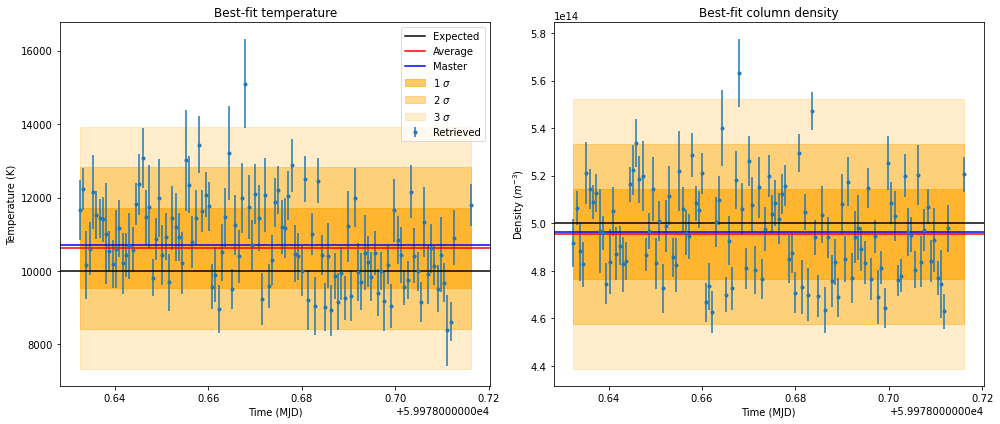

In [20]:
reload(AF)

#Defining a variable to save or not the results.
save = True

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig , ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[18, 12])
    
    #Defining the average and standard deviation of the retrieved temperatures.
    weighted_avg_T_HA = np.average(param_HA[:, 0], weights=1/err_HA[:, 0]**2)
    weighted_std_T_HA = np.sqrt(np.average((param_HA[:, 0] - weighted_avg_T_HA)**2, weights=1/err_HA[:, 0]**2))
    
    #Plotting the retrieved temperatures.
    ax1.errorbar(date_in_transit_HA, param_HA[:, 0], yerr = err_HA[:, 0], fmt='.', label='Retrieved')
    ax1.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Best-fit temperature for HA')
    ax1.axhline(temperature, color='k', label='Expected')
    ax1.axhline(weighted_avg_T_HA, color='r', label='Average')
    ax1.axhline(param_master_HA[0], color='b', label='Master')
    ax1.fill_between(date_in_transit_HA, y1 = weighted_avg_T_HA-weighted_std_T_HA, y2 = weighted_avg_T_HA+weighted_std_T_HA, alpha=0.6, color='orange', label='1 $\sigma$')
    ax1.fill_between(date_in_transit_HA, y1 = weighted_avg_T_HA-2*weighted_std_T_HA, y2 = weighted_avg_T_HA+2*weighted_std_T_HA, alpha=0.4, color='orange', label='2 $\sigma$')
    ax1.fill_between(date_in_transit_HA, y1 = weighted_avg_T_HA-3*weighted_std_T_HA, y2 = weighted_avg_T_HA+3*weighted_std_T_HA, alpha=0.2, color='orange', label='3 $\sigma$')
    ax1.legend(framealpha=0.8)
    
    #Defining the average and standard deviation of the retrieved temperatures.
    weighted_avg_T_HE = np.average(param_HE[:, 0], weights=1/err_HE[:, 0]**2)
    weighted_std_T_HE = np.sqrt(np.average((param_HE[:, 0] - weighted_avg_T_HE)**2, weights=1/err_HE[:, 0]**2))
    
    #Plotting the retrieved temperatures.
    ax2.errorbar(date_in_transit_HE, param_HE[:, 0], yerr = err_HE[:, 0], fmt='.', label='Retrieved')
    ax2.set_xlabel('Time (MJD)')
    ax2.set_ylabel('Temperature (K)')
    ax2.set_title('Best-fit temperature for HE')
    ax2.axhline(temperature, color='k', label='Expected')
    ax2.axhline(weighted_avg_T_HE, color='r', label='Average')
    ax2.axhline(param_master_HE[0], color='b', label='Master')
    ax2.fill_between(date_in_transit_HE, y1 = weighted_avg_T_HE-weighted_std_T_HE, y2 = weighted_avg_T_HE+weighted_std_T_HE, alpha=0.6, color='orange', label='1 $\sigma$')
    ax2.fill_between(date_in_transit_HE, y1 = weighted_avg_T_HE-2*weighted_std_T_HE, y2 = weighted_avg_T_HE+2*weighted_std_T_HE, alpha=0.4, color='orange', label='2 $\sigma$')
    ax2.fill_between(date_in_transit_HE, y1 = weighted_avg_T_HE-3*weighted_std_T_HE, y2 = weighted_avg_T_HE+3*weighted_std_T_HE, alpha=0.2, color='orange', label='3 $\sigma$')
    
    #Defining the average and standard deviation of the retrieved densities.
    weighted_avg_rho_HA = np.average(param_HA[:, 1], weights=1/err_HA[:, 1]**2)
    weighted_std_rho_HA = np.sqrt(np.average((param_HA[:, 1] - weighted_avg_rho_HA)**2, weights=1/err_HA[:, 1]**2))
    
    #Plotting the retrieved densities.
    ax3.errorbar(date_in_transit_HA, param_HA[:, 1], yerr = err_HA[:, 1], fmt='.', label='Retrieved')
    ax3.set_xlabel('Time (MJD)')
    ax3.set_ylabel('Density ($m^{-3}$)')
    ax3.set_title('Best-fit column density for HA')
    ax3.axhline(density, color='k', label='Expected')
    ax3.axhline(weighted_avg_rho_HA, color='r', label='Average')
    ax3.axhline(-param_master_HA[1], color='b', label='Master')
    ax3.fill_between(date_in_transit_HA, y1 = weighted_avg_rho_HA-weighted_std_rho_HA, y2 = weighted_avg_rho_HA+weighted_std_rho_HA, alpha=0.6, color='orange', label='1 $\sigma$')
    ax3.fill_between(date_in_transit_HA, y1 = weighted_avg_rho_HA-2*weighted_std_rho_HA, y2 = weighted_avg_rho_HA+2*weighted_std_rho_HA, alpha=0.4, color='orange', label='2 $\sigma$')
    ax3.fill_between(date_in_transit_HA, y1 = weighted_avg_rho_HA-3*weighted_std_rho_HA, y2 = weighted_avg_rho_HA+3*weighted_std_rho_HA, alpha=0.2, color='orange', label='3 $\sigma$')

    #Defining the average and standard deviation of the retrieved densities.
    weighted_avg_rho_HE = np.average(param_HE[:, 1], weights=1/err_HE[:, 1]**2)
    weighted_std_rho_HE = np.sqrt(np.average((param_HE[:, 1] - weighted_avg_rho_HE)**2, weights=1/err_HE[:, 1]**2))
    
    #Plotting the retrieved densities.
    ax4.errorbar(date_in_transit_HE, param_HE[:, 1], yerr = err_HE[:, 1], fmt='.', label='Retrieved ')
    ax4.set_xlabel('Time (MJD)')
    ax4.set_ylabel('Density ($m^{-3}$)')
    ax4.set_title('Best-fit column density for HE')
    ax4.axhline(density, color='k', label='Expected')
    ax4.axhline(weighted_avg_rho_HE, color='r', label='Average')
    ax4.axhline(-param_master_HE[1], color='b', label='Master')
    ax4.fill_between(date_in_transit_HE, y1 = weighted_avg_rho_HE-weighted_std_rho_HE, y2 = weighted_avg_rho_HE+weighted_std_rho_HE, alpha=0.6, color='orange', label='1 $\sigma$')
    ax4.fill_between(date_in_transit_HE, y1 = weighted_avg_rho_HE-2*weighted_std_rho_HE, y2 = weighted_avg_rho_HE+2*weighted_std_rho_HE, alpha=0.4, color='orange', label='2 $\sigma$')
    ax4.fill_between(date_in_transit_HE, y1 = weighted_avg_rho_HE-3*weighted_std_rho_HE, y2 = weighted_avg_rho_HE+3*weighted_std_rho_HE, alpha=0.2, color='orange', label='3 $\sigma$')

    ax1.sharey(ax2)
    ax3.sharey(ax4)

    fig.tight_layout()
    if save:
        plt.savefig(location+'/Plot_Results/Retrieved_Params.pdf')

#If there is one mode of observation
else:
    
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 6])
    
    #Defining the average and standard deviation of the retrieved temperatures.
    weighted_avg_T = np.average(param[:, 0], weights=1/err[:, 0]**2)
    weighted_std_T = np.sqrt(np.average((param[:, 0] - weighted_avg_T)**2, weights=1/err[:, 0]**2))
    
    #Plotting the retrieved temperatures.
    ax1.errorbar(date_in_transit, param[:, 0], yerr = err[:, 0], fmt='.', label='Retrieved')
    ax1.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Best-fit temperature')
    ax1.axhline(temperature, color='k', label='Expected')
    ax1.axhline(weighted_avg_T, color='r', label='Average')
    ax1.axhline(param_master[0], color='b', label='Master')
    ax1.fill_between(date_in_transit, y1 = weighted_avg_T-weighted_std_T, y2 = weighted_avg_T+weighted_std_T, alpha=0.6, color='orange', label='1 $\sigma$')
    ax1.fill_between(date_in_transit, y1 = weighted_avg_T-2*weighted_std_T, y2 = weighted_avg_T+2*weighted_std_T, alpha=0.4, color='orange', label='2 $\sigma$')
    ax1.fill_between(date_in_transit, y1 = weighted_avg_T-3*weighted_std_T, y2 = weighted_avg_T+3*weighted_std_T, alpha=0.2, color='orange', label='3 $\sigma$')
    ax1.legend(framealpha=.7)

    #Defining the average and standard deviation of the retrieved densities.
    weighted_avg_rho = np.average(param[:, 1], weights=1/err[:, 1]**2)
    weighted_std_rho = np.sqrt(np.average((param[:, 1] - weighted_avg_rho)**2, weights=1/err[:, 1]**2))
        
    #Plotting the retrieved densities.
    ax2.errorbar(date_in_transit, param[:, 1], yerr = err[:, 1], fmt='.', label='Retrieved')
    ax2.set_xlabel('Time (MJD)')
    ax2.set_ylabel('Density ($m^{-3}$)')
    ax2.set_title('Best-fit column density')
    ax2.axhline(density, color='k', label='Expected')
    ax2.axhline(weighted_avg_rho, color='r', label='Average')
    ax2.axhline(-param_master[1], color='b', label='Master')
    ax2.fill_between(date_in_transit, y1 = weighted_avg_rho-weighted_std_rho, y2 = weighted_avg_rho+weighted_std_rho, alpha=0.6, color='orange', label='1 $\sigma$')
    ax2.fill_between(date_in_transit, y1 = weighted_avg_rho-2*weighted_std_rho, y2 = weighted_avg_rho+2*weighted_std_rho, alpha=0.4, color='orange', label='2 $\sigma$')
    ax2.fill_between(date_in_transit, y1 = weighted_avg_rho-3*weighted_std_rho, y2 = weighted_avg_rho+3*weighted_std_rho, alpha=0.2, color='orange', label='3 $\sigma$')

    fig.tight_layout()
    if save:
        plt.savefig(location+'/Plot_Results/Retrieved_Params.pdf')
   